In [ ]:
from datetime import datetime, timedelta, timezone
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, mode, skew, kurtosis, linregress
import xgboost as xgb
from joblib import Parallel, delayed
import sklearn
import pickle
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, ShuffleSplit, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import mean_squared_error as MSE
import zipfile
import warnings
import seaborn as sns
import joblib
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import multiprocessing as mp

# sns.set_style("white")


# plt.rcParams["text.usetex"] = True
# font = {"family": "normal", "weight": "bold", "size": 22}

# plt.rc("font", **font)

CM_LAG_CORRECTION = [
    ("p1", timedelta(minutes=2 * 60 + 36)),
    ("p3", timedelta(minutes=2 * 60)),
    ("p5", timedelta(minutes=-360)),
    ("p6", timedelta(minutes=-360)),
    ("p7", timedelta(minutes=-360)),
    ("p8", timedelta(minutes=-360)),
    # ("p8", datetime.strptime("02 02 2022-00:00:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 06 2022-07:20:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=-165)),
    # ("p8", datetime.strptime("02 06 2022-07:20:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 09 2022-00:00:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=-165-190)),
    # ("p8", datetime.strptime("02 09 2022-07:20:00", "%m %d %Y-%H:%M:%S"),datetime.strptime("02 14 2022-00:00:00", "%m %d %Y-%H:%M:%S"),timedelta(minutes=93)),
]
# CGM_LAG_IMPOSING_STR = sys.argv[1]# ONLY TO IMPOSE A TIME LAG BETWEEN CGM READINGS AND CORE MOTION DATA!!!! WATCH OUT AND USE IT CAUTIOUSLY
CGM_LAG_IMPOSING_STR = "0"
# OUTTER_WINDOW_LENGTH = timedelta(minutes=int(sys.argv[2]))


CGM_LAG_IMPOSING = timedelta(minutes=int(CGM_LAG_IMPOSING_STR))  # ONLY TO IMPOSE A TIME LAG BETWEEN CGM READINGS AND CORE MOTION DATA!!!! WATCH OUT AND USE IT CAUTIOUSLY
OUTTER_WINDOW_LENGTH = timedelta(minutes=60)
OUTTER_WINDOW_STEP = timedelta(minutes=15)
FASTING_LENGTH = timedelta(minutes=30)
BIG_MEAL_CALORIE = 200
FOLD_NUMBER = 5
INNER_WINDOW_LENGTH = timedelta(seconds=60)
MINIMUM_POINT = INNER_WINDOW_LENGTH.total_seconds()
COMPLEX_MEAL_DURATION = timedelta(minutes=60)


START_OF_TRIAL = [datetime.strptime("11 06 2021-04:00:00", "%m %d %Y-%H:%M:%S"), datetime.strptime("02 03 2022-00:00:00", "%m %d %Y-%H:%M:%S")]
END_OF_TRIAL = [datetime.strptime("11 15 2021-00:00:00", "%m %d %Y-%H:%M:%S"), datetime.strptime("02 13 2022-00:00:00", "%m %d %Y-%H:%M:%S")]
DAY_LIGHT_SAVING = datetime.strptime("11 06 2021-02:00:00", "%m %d %Y-%H:%M:%S")
coreNumber = 48

addDataPrefix = "/Users/sorush/My Drive/Documents/Educational/TAMU/Research/TAMU/"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "/home/grads/s/sorush.omidvar/CGMDataset/TAMU/"
if not os.path.exists(addDataPrefix):
    addDataPrefix = "C:\\GDrive\\Documents\\Educational\\TAMU\\Research\\Trial\\Data\\11-5-21-11-15-21"

addUserInput = os.path.join(addDataPrefix, "User inputted")
addHKCM = os.path.join(addDataPrefix, "hk+cm")
addCGM = os.path.join(addDataPrefix, "CGM")
addE4 = os.path.join(addDataPrefix, "E4")
addResults = os.path.join(addDataPrefix, "Results" + str(CGM_LAG_IMPOSING_STR))
if not os.path.exists(addResults):
    os.mkdir(addResults)

exempts = ["p2", "p4"]

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({"figure.facecolor": "white"})
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # no GPU


warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 500)


In [ ]:
# participants=list(set(dfMeal['Participant'].to_list()))
# participants.sort()
# # dfMeal.insert(0,'Duration',0)
# # dfMeal['Duration']=dfMeal['FinishTime']-dfMeal['StartTime']
# for participant in participants:
#     dfTemp=dfMeal[dfMeal['Participant']==participant]
#     print(participant,'&',len(dfTemp),'&',np.round(dfTemp['Duration'].dt.total_seconds().mean()/60,1),'(',np.round(dfTemp['Duration'].dt.total_seconds().std()/60,1),')','&',np.round(dfTemp['Calories'].mean(),1),"(",np.round(dfTemp['Calories'].std(),1),")",'&',np.round(dfTemp['Carbs'].mean(),1),"(",np.round(dfTemp['Carbs'].std(),1),")",'&',np.round(dfTemp['Fat'].mean(),1),"(",np.round(dfTemp['Fat'].std(),1),")",'&',np.round(dfTemp['Protein'].mean(),1),"(",np.round(dfTemp['Protein'].std(),1),")")


In [ ]:
# files = os.listdir(addResults)
# for item in files:
#     if ".xlsx" in item or '.jpg' in item or 'All-Features' in item:
#         os.remove(os.path.join(addResults, item))


In [ ]:
# T1 = datetime.strptime("02 03 2022-00:00:00", "%m %d %Y-%H:%M:%S")
# T2=T1+timedelta(hours=120)
# a=dfE4[(dfE4['Time']>=T1) &(dfE4['Time']<=T2)]

# plt.figure(figsize=(40,10))
# x=a['Time'].to_list()
# x=np.asarray(x)
# y=a['Data1'].to_list()
# plt.scatter(x,y)
# plt.grid(which='both',color='r', linestyle='-', linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1,T2])


# plt.figure(figsize=(40,10))
# b=dfCM[(dfCM['Time']>=T1) &(dfCM['Time']<=T2)]
# x=b['Time'].to_list()
# x=np.asarray(x)
# y=b['Yaw'].to_list()
# y=np.asarray(y)/10+70
# plt.scatter(x,y)
# plt.grid(which='both',color='r', linestyle='-', linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1,T2])


In [ ]:
# def unzipperE4(participantFolder):
#     for root, dirs, files in os.walk(participantFolder):
#         for file in files:
#             if not '.zip' in file:
#                 continue
#             with zipfile.ZipFile(os.path.join(root,file), 'r') as zip_ref:
#                 destFile=file[:file.find('.zip')]
#                 destFile=os.path.join(root,destFile)
#                 if not os.path.exists(destFile):
#                     os.mkdir(destFile)
#                 zip_ref.extractall(destFile)
# def zipCleanerE4(E4Folder):
#     for root, dirs, files in os.walk(E4Folder):
#         for file in files:
#             if '.zip' in file:
#                 os.remove(os.path.join(root,file))

# unzipperE4('/Users/sorush/Desktop/Round2E4/p5')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p6')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p7')
# unzipperE4('/Users/sorush/Desktop/Round2E4/p8')
# zipCleanerE4('/Users/sorush/Desktop/Round2E4')


In [ ]:
def timeZoneFixer(df, LocalizeFlag, columnName):
    if LocalizeFlag:
        df[columnName] -= timedelta(hours=5)
    tempColumn = df[columnName]
    tempColumn[tempColumn >= DAY_LIGHT_SAVING] -= timedelta(hours=1)
    df[columnName] = tempColumn
    return df


def trialTimeLimitter(df, columnName):
    participants = list(set(df["Participant"].to_list()))
    dfTotal = []
    for participant in participants:
        if participant == "p1" or participant == "p2" or participant == "p3" or participant == "p4":
            startOfTrial = START_OF_TRIAL[0]
            endOfTrial = END_OF_TRIAL[0]
        elif participant == "p5" or participant == "p6" or participant == "p7" or participant == "p8":
            startOfTrial = START_OF_TRIAL[1]
            endOfTrial = END_OF_TRIAL[1]
        else:
            print("Mayday in trialTimeLimitter")
            print(participant)
            raise
        dfTemp = df[df["Participant"] == participant]
        dfTemp = dfTemp[(dfTemp[columnName] >= startOfTrial) & (dfTemp[columnName] <= endOfTrial)]
        if len(dfTotal) == 0:
            dfTotal = dfTemp
        else:
            frames = [dfTotal, dfTemp]
            dfTotal = pd.concat(frames)
    return dfTotal


def mealMarker(df):
    df.insert(len(df.columns), "BigMeal", False)
    for counter in range(0, len(df)):
        if df["Calories"].iloc[counter] >= BIG_MEAL_CALORIE:
            df["BigMeal"].iloc[counter] = True

    df.insert(len(df.columns), "ComplexMeal", False)
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    for participant in participants:
        dfTemp = df[df["Participant"] == participant]
        for counter in range(1, len(dfTemp)):
            # bothComplexFlag = dfTemp["BigMeal"].iloc[counter - 1] and dfTemp["BigMeal"].iloc[counter]
            # if dfTemp["StartTime"].iloc[counter - 1] + OUTTER_WINDOW_LENGTH >= dfTemp["StartTime"].iloc[counter] and bothComplexFlag:
            if dfTemp["StartTime"].iloc[counter - 1] + COMPLEX_MEAL_DURATION >= dfTemp["StartTime"].iloc[counter]:
                dfTemp["ComplexMeal"].iloc[counter] = True
                dfTemp["ComplexMeal"].iloc[counter - 1] = True
        indexs = dfTemp.index[dfTemp["ComplexMeal"] == True]
        df["ComplexMeal"][indexs] = True
    return df


if os.path.exists(os.path.join(addResults, "All_meals.pkl")):
    os.remove(os.path.join(addResults, "All_meals.pkl"))
os.chdir(addUserInput)
if not os.path.exists(os.path.join(addResults, "All_meals.pkl")):
    dfMeal = []
    for root, dirs, files in os.walk(addUserInput):
        print(root)
        for file in files:
            if ".csv" in file.lower():
                if "meals" in file.lower() and "modified" not in file.lower():
                    participantName = file[: file.find("Meals")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    dfTemp.insert(0, "Participant", participantName)
                    dfTemp.rename(columns={"startTime": "StartTime"}, inplace=True)
                    dfTemp["StartTime"] = pd.to_datetime(dfTemp["StartTime"])
                    dfTemp["FinishTime"] = pd.to_datetime(dfTemp["FinishTime"])
                    dfTemp.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)

                    if len(dfMeal) != 0:
                        frames = [dfTemp, dfMeal]
                        dfMeal = pd.concat(frames)
                    else:
                        dfMeal = dfTemp
    print("reading is done")
    dfMeal = trialTimeLimitter(dfMeal, "StartTime")
    dfMeal = trialTimeLimitter(dfMeal, "FinishTime")
    dfMeal.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    dfMeal.reset_index(drop=True, inplace=True)
    # dfMeal.insert(4, "MealDuration", -1)
    # dfMeal["MealDuration"] = dfMeal["FinishTime"] - dfMeal["StartTime"]
    # dfMeal["MealDuration"] = dfMeal["MealDuration"].dt.total_seconds()
    print("Meal database is limited to the trial period")
    dfMeal.to_pickle(os.path.join(addResults, "All_meals.pkl"))
else:
    dfMeal = pd.read_pickle(os.path.join(addResults, "All_meals.pkl"))
dfMeal = mealMarker(dfMeal)


In [ ]:
def pdInterpolation(dfTemp):
    index = dfTemp["Time"]
    seriesParticipant = pd.Series(dfTemp["Abbot"].to_list(), index=index)
    seriesParticipant = seriesParticipant.resample("1T").asfreq()
    seriesParticipant.interpolate(method="polynomial", order=3, inplace=True)
    tempTime = seriesParticipant.index
    tempVal = seriesParticipant.values
    dfTemp = pd.DataFrame(zip(tempTime, tempVal), columns=["Time", "Abbot"])
    return dfTemp


def cmLagCorrector(df):
    participants = df["Participant"].to_list()
    participants = list(set(participants))
    dfTotal = []

    for element in CM_LAG_CORRECTION:
        participant = element[0]
        timeLag = element[1]
        dfParticipant = df[df["Participant"] == participant]
        if len(dfParticipant) == 0:
            continue
        dfParticipant["Time"] += timeLag
        if len(dfTotal) == 0:
            dfTotal = dfParticipant
        else:
            frames = [dfTotal, dfParticipant]
            dfTotal = pd.concat(frames)

    return dfTotal


def cmSmoother(df):
    columnLabels = df.columns
    for columnLabel in columnLabels:
        if columnLabel == "Time":
            continue
        tempSerie = df[columnLabel]
        tempSerie = tempSerie.ewm(span=10).mean()  # Considering the frequency of 10 Hz
        df[columnLabel] = tempSerie
    return df


def CGMLagImposer(df):
    df["Time"] += CGM_LAG_IMPOSING
    return df


def CGMNormalizer(df):
    participants = list(set(df["Participant"].to_list()))
    participants.sort()
    dfResult = []
    for participant in participants:
        dfParticipant = df[df["Participant"] == participant]
        dates = list(set(dfParticipant["Time"].dt.date.to_list()))
        dates.sort()
        for date in dates:
            dfDate = dfParticipant[dfParticipant["Time"].dt.date == date]
            if len(dfDate) <= 10:
                continue
            minBG = dfDate["Abbot"].min()
            maxBG = dfDate["Abbot"].max()

            meanBG = dfDate["Abbot"].mean()
            stdBG = dfDate["Abbot"].std()
            dfDate["Abbot"] -= minBG
            dfDate["Abbot"] /= maxBG - minBG
            # dfDate["Abbot"] -= meanBG
            # dfDate["Abbot"] /= stdBG

            assert not np.isnan(minBG)
            assert not np.isnan(maxBG)
            assert not np.isnan(meanBG)
            assert not np.isnan(stdBG)
            if len(dfResult) == 0:
                dfResult = dfDate.copy()
            else:
                frames = [dfResult, dfDate]
                dfResult = pd.concat(frames)
    return dfResult


def CGMLowPass(df):
    participants = list(set(df["Participant"].to_list()))
    participants.sort()
    dfResult = []
    for participant in participants:
        dfParticipant = df[df["Participant"] == participant]
        cgmVals = dfParticipant["Abbot"].to_list()
        cgmVals = np.asarray(cgmVals)
        lowPassFilter = signal.butter(3, 12, "lp", fs=60 * 24, output="sos")  # high pass of period of 2 hours (12 per day)
        cgmVals = signal.sosfilt(lowPassFilter, cgmVals)
        dfParticipant["Abbot"] = cgmVals
        if len(dfResult) == 0:
            dfResult = dfParticipant.copy()
        else:
            frames = [dfResult, dfParticipant]
            dfResult = pd.concat(frames)
    return dfResult


if os.path.exists(os.path.join(addResults, "All_cgm.pkl")):
    os.remove(os.path.join(addResults, "All_cgm.pkl"))
if not os.path.exists(os.path.join(addResults, "All_cgm.pkl")):
    os.chdir(addCGM)
    dfCGM = []
    for root, dirs, files in os.walk(addCGM):
        for file in files:
            if ".txt" in file.lower():
                if "_libre" in file.lower():
                    participantName = file[: file.find("_libre")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file, sep="\t", skiprows=1)
                    if len(dfTemp.columns) != 4:
                        print("MAYDAY. Error in reading csv")
                        break
                    dfTemp.columns.values[0] = "ID"
                    dfTemp.columns.values[1] = "Time"
                    dfTemp.columns.values[2] = "Record"
                    dfTemp.columns.values[3] = "Abbot"
                    dfTemp.drop(columns=["ID", "Record"], inplace=True)
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"])
                    if participantName == "p1" or participantName == "p2" or participantName == "p3" or participantName == "p4":
                        dfTemp["Time"] += timedelta(hours=-1)  # This fixes the daylight saving for the first round
                    dfTemp["Abbot"] = pd.to_numeric(dfTemp["Abbot"])
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)
                    dfTemp = pdInterpolation(dfTemp)
                    dfTemp.insert(0, "Participant", participantName)
                    if len(dfTemp.columns) != 3:
                        print("MAYDAY. Error in processing csv")
                        break
                    if len(dfCGM) != 0:
                        frames = [dfTemp, dfCGM]
                        dfCGM = pd.concat(frames)
                    else:
                        dfCGM = dfTemp
    print("reading is done")
    dfCGM = CGMLagImposer(dfCGM)
    dfCGM = trialTimeLimitter(dfCGM, "Time")
    dfCGM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfCGM.reset_index(drop=True, inplace=True)
    # dfCGM = CGMLowPass(dfCGM)
    # dfCGM = CGMNormalizer(dfCGM)
    dfCGM.reset_index(drop=True, inplace=True)
    print("CGM database is limited to the trial period")
    dfCGM.to_pickle(os.path.join(addResults, "All_cgm.pkl"))
else:
    dfCGM = pd.read_pickle(os.path.join(addResults, "All_cgm.pkl"))


# if os.path.exists(os.path.join(addResults, "All_cm.pkl")):
#     os.remove(os.path.join(addResults, "All_cm.pkl"))
os.chdir(addHKCM)
if not os.path.exists(os.path.join(addResults, "All_cm.pkl")):
    dfCM = []
    for root, dirs, files in os.walk(addHKCM):
        for file in files:
            if ".csv" in file.lower():
                if "corrected_cm_all" in file.lower():
                    participantName = file[: file.find("_corrected")]
                    if participantName in exempts:
                        print("Exemption...", file)
                        continue
                    print("Reading ...", file)
                    dfTemp = pd.read_csv(file)
                    print("File is read")
                    dfTemp["UnixTime"] = pd.to_datetime(dfTemp["UnixTime"], unit="s")

                    dfTemp.rename(columns={"UnixTime": "Time"}, inplace=True)
                    dfTemp.drop(columns=["UID", "Date"], inplace=True)
                    dfTemp.sort_values(["Time"], ascending=(True), inplace=True)
                    dfTemp.reset_index(drop=True, inplace=True)

                    dfTemp = cmSmoother(dfTemp)
                    dfTemp["Yaw"] *= 180 / np.pi
                    dfTemp["Pitch"] *= 180 / np.pi
                    dfTemp["Roll"] *= 180 / np.pi

                    dfTemp.insert(0, "Participant", participantName)
                    # this is to avoid 0 later on for feature calculation
                    dfTemp.insert(len(dfTemp.columns), "|Ax|+|Ay|+|Az|", dfTemp["Ax"].abs() + dfTemp["Ay"].abs() + dfTemp["Az"].abs() + 0.0001)
                    dfTemp.insert(len(dfTemp.columns), "|Yaw|+|Roll|+|Pitch|", dfTemp["Yaw"].abs() + dfTemp["Roll"].abs() + dfTemp["Pitch"].abs())
                    dfTemp.insert(len(dfTemp.columns), "|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|", dfTemp["Rx"].abs() + dfTemp["Ry"].abs() + dfTemp["Rz"].abs())
                    dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] = dfTemp["|Rx|+|Ry|+|Rz|To|Ax|+|Ay|+|Az|"] / dfTemp["|Ax|+|Ay|+|Az|"]
                    dfTemp.insert(len(dfTemp.columns), "RotationalToLinear", dfTemp["|Yaw|+|Roll|+|Pitch|"] / dfTemp["|Ax|+|Ay|+|Az|"])
                    print("modified")

                    if len(dfTemp.columns) != 15:
                        print("MAYDAY. Error in reading csv")
                        print(dfTemp.columns)
                        break
                    if len(dfCM) != 0:
                        frames = [dfTemp, dfCM]
                        dfCM = pd.concat(frames)
                    else:
                        dfCM = dfTemp
    print("Processing is done")
    dfCM = cmLagCorrector(dfCM)
    dfCM = trialTimeLimitter(dfCM, "Time")
    dfCM.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfCM.reset_index(drop=True, inplace=True)
    print("CM database is limited to the trial period")
    dfCM.to_pickle(os.path.join(addResults, "All_cm.pkl"))
else:
    dfCM = pd.read_pickle(os.path.join(addResults, "All_cm.pkl"))


# if os.path.exists(os.path.join(addResults, "All_E4.pkl")):
#     os.remove(os.path.join(addResults, "All_E4.pkl"))
os.chdir(addE4)
# fields=['ACC','BVP','EDA','HR','IBI','TEMP']
fields = ["HR", "TEMP", "EDA"]
if not os.path.exists(os.path.join(addResults, "All_E4.pkl")):
    dfE4 = []
    for root, dirs, files in os.walk(addE4):
        for file in files:
            if ".csv" in file.lower():
                participantName = root[root.find("E4") + 3 :]
                participantName = participantName[:2]
                field = file[: file.find(".csv")]
                if field not in fields:
                    print("File name does not comply with analyzed fields", file)
                    continue
                print(participantName, field)
                if participantName in exempts:
                    print("Exemption...", file)
                    continue
                print("Reading ...", file)
                os.chdir(root)
                dfTemp = pd.read_csv(file, header=None)
                # if field=='ACC':
                #     assert len(dfTemp.columns)==3
                #     timeBase=dfTemp.iloc[0,0]
                #     timeStep=1/dfTemp.iloc[1,0]
                #     dfTemp.drop([0,1],inplace=True)
                #     dfTemp.rename(columns={0:'Data1',1:'Data2',2:'Data3'}, inplace=True)#x,y,z for data1,data2,data3
                #     timeTemp=[]
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase+counter*timeStep)
                #     dfTemp.insert(0,'Time',timeTemp)
                #     dfTemp.insert(0,'Field',"Acceleration")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                # if field == "BVP":
                #     assert len(dfTemp.columns) == 1
                #     timeBase = dfTemp.iloc[0, 0]
                #     timeStep = 1 / dfTemp.iloc[1, 0]
                #     dfTemp.drop([0, 1], inplace=True)
                #     dfTemp.rename(columns={0: "Data1"}, inplace=True)
                #     dfTemp["Data2"] = ""
                #     dfTemp["Data3"] = ""
                #     timeTemp = []
                #     for counter in range(len(dfTemp)):
                #         timeTemp.append(timeBase + counter * timeStep)
                #     dfTemp.insert(0, "Time", timeTemp)
                #     dfTemp.insert(0, "Field", "BVP")
                #     dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                if field == "HR":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "HR")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                elif field == "EDA":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "EDA")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                # elif field=='IBI':
                #     assert len(dfTemp.columns)==2
                #     timeBase=dfTemp.iloc[0,0]
                #     dfTemp.drop([0],inplace=True)
                #     dfTemp.rename(columns={0:'Time',1:'Data1'}, inplace=True)
                #     dfTemp["Data2"]=""
                #     dfTemp["Data3"]=""
                #     timeTemp=[]
                #     dfTemp['Time']+=timeBase
                #     dfTemp.insert(0,'Field',"IBI")
                #     dfTemp['Time'] = pd.to_datetime(dfTemp['Time'],unit='s')
                elif field == "TEMP":
                    assert len(dfTemp.columns) == 1
                    timeBase = dfTemp.iloc[0, 0]
                    timeStep = 1 / dfTemp.iloc[1, 0]
                    dfTemp.drop([0, 1], inplace=True)
                    dfTemp.rename(columns={0: "Data1"}, inplace=True)
                    dfTemp["Data2"] = ""
                    dfTemp["Data3"] = ""
                    timeTemp = []
                    for counter in range(len(dfTemp)):
                        timeTemp.append(timeBase + counter * timeStep)
                    dfTemp.insert(0, "Time", timeTemp)
                    dfTemp.insert(0, "Field", "Temperature")
                    dfTemp["Time"] = pd.to_datetime(dfTemp["Time"], unit="s")
                dfTemp.insert(0, "Participant", participantName)
                dfTemp.sort_values(["Participant", "Field", "Time"], ascending=(True, True, True), inplace=True)
                dfTemp.reset_index(drop=True, inplace=True)
                if len(dfTemp.columns) != 6:
                    print("MAYDAY. Error in reading csv")
                    break
                if len(dfE4) != 0:
                    frames = [dfTemp, dfE4]
                    dfE4 = pd.concat(frames)
                else:
                    dfE4 = dfTemp
    print("reading is done")
    dfE4 = timeZoneFixer(dfE4, True, "Time")
    dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfE4.reset_index(drop=True, inplace=True)
    dfE4 = trialTimeLimitter(dfE4, "Time")
    dfE4.sort_values(["Participant", "Time"], ascending=(True, True), inplace=True)
    dfE4.reset_index(drop=True, inplace=True)
    print("E4 database is limited to the trial period")
    dfE4.to_pickle(os.path.join(addResults, "All_E4.pkl"))
else:
    dfE4 = pd.read_pickle(os.path.join(addResults, "All_E4.pkl"))


In [ ]:
# participants = list(set(dfCGM["Participant"].to_list()))
# participants.sort()
# for participant in participants:
#     dfCGMTemp = dfCGM[dfCGM["Participant"] == participant]
#     dfMealTemp = dfMeal[dfMeal["Participant"] == participant]
#     riseDuration = []
#     for counter in range(len(dfMealTemp) - 1):
#         currentMealStart = dfMealTemp.iloc[counter]["StartTime"]
#         cgmValBase = dfCGMTemp[dfCGMTemp["Time"] == currentMealStart]

#         assert len(cgmValBase) == 1
#         cgmValBase = cgmValBase["Abbot"].values[0]
#         for counter in range(45):
#             timeTempMin = timedelta(minutes=counter)
#             cgmVal = dfCGMTemp[dfCGMTemp["Time"] == currentMealStart + timeTempMin]
#             assert len(cgmVal) == 1
#             cgmVal = cgmVal["Abbot"].values[0]
#             if cgmVal - cgmValBase >= 15:
#                 riseDuration.append([counter, cgmValBase, cgmVal])
#                 break
#     riseDuration = np.asarray(riseDuration)
#     print("BG average rise time for each participants over all meals:", participant, np.mean(riseDuration[:, 0]))


In [ ]:
# T1 = datetime.strptime("11 06 2021-00:00:00", "%m %d %Y-%H:%M:%S")
# T2 = T1 + timedelta(hours=120)
# myParticipant = "p1"
# a = dfE4[dfE4["Participant"] == myParticipant]
# a = a[a["Field"] == "HR"]
# a = a[(a["Time"] >= T1) & (a["Time"] <= T2)]

# plt.figure(figsize=(40, 10))
# x = a["Time"].to_list()
# x = np.asarray(x)
# y = a["Data1"].to_list()
# plt.scatter(x, y)
# plt.grid(which="both", color="r", linestyle="-", linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1, T2])


# plt.figure(figsize=(40, 10))
# b = dfCM[dfCM["Participant"] == myParticipant]
# b = b[(b["Time"] >= T1) & (b["Time"] <= T2)]
# x = b["Time"].to_list()
# x = np.asarray(x)
# y = b["Yaw"].to_list()
# y = np.asarray(y) / 10 + 70
# plt.scatter(x, y)
# plt.grid(which="both", color="r", linestyle="-", linewidth=0.5)
# plt.minorticks_on()
# plt.xlim([T1, T2])



In [ ]:
# fig=plt.figure(figsize=(18,24))
# plt.subplot(6,1,1)
# participant='p8'
# colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# T1 = datetime.strptime("02 03 2022-12:00:00", "%m %d %Y-%H:%M:%S")  # to handle the daylight saving issue in apple watches
# T2 = T1 + timedelta(hours=5)
# dfTempCGM=dfCGM[dfCGM['Participant']==participant]
# dfTempCGM=dfTempCGM[(dfTempCGM['Time']>=T1) & (dfTempCGM['Time']<T2)]

# x=dfTempCGM['Time'].to_list()
# y=dfTempCGM['Abbot'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# x=x[1:len(x):15]
# y=y[1:len(y):15]
# myAx=plt.plot(x,y, '-*',c=colors[0])
# frame1 = plt.gca()
# frame1.axes.set_xticks([12,14,16,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([12,17])
# frame1.axes.yaxis.set_label_coords(-0.1,0.5)
# plt.ylabel('BG [mg/dL]')
# plt.scatter(x=12+43/60,y=120,color='red')


# plt.subplot(6,1,2)
# dfTempE4=dfE4[dfE4['Participant']==participant]
# dfTempE4=dfTempE4[(dfTempE4['Time']>=T1) & (dfTempE4['Time']<T2) &(dfTempE4['Field']=='HR')]

# x=dfTempE4['Time'].to_list()
# y=dfTempE4['Data1'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[1])
# frame1 = plt.gca()
# frame1.axes.set_xticks([12,14,16,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([11,17])
# frame1.axes.yaxis.set_label_coords(-0.1,0.5)
# plt.ylabel('Heart Rate [BPM]')

# plt.subplot(6,1,3)
# dfTempE4=dfE4[dfE4['Participant']==participant]
# dfTempE4=dfTempE4[(dfTempE4['Time']>=T1) & (dfTempE4['Time']<T2) &(dfTempE4['Field']=='Temperature')]

# x=dfTempE4['Time'].to_list()
# y=dfTempE4['Data1'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[3])
# frame1 = plt.gca()
# frame1.axes.set_xticks([12,14,16,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([12,17])
# frame1.axes.yaxis.set_label_coords(-0.1,0.5)
# plt.ylabel('Temperature [$^\circ$C]')


# plt.subplot(6,1,4)
# dfTempE4=dfE4[dfE4['Participant']==participant]
# dfTempE4=dfTempE4[(dfTempE4['Time']>=T1) & (dfTempE4['Time']<T2) &(dfTempE4['Field']=='EDA')]

# x=dfTempE4['Time'].to_list()
# y=dfTempE4['Data1'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[4])
# frame1 = plt.gca()
# frame1.axes.set_xticks([12,14,16,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([12,17])
# frame1.axes.yaxis.set_label_coords(-0.1,0.5)
# plt.ylabel('EDA [$^\mu$S]')


# plt.subplot(6,1,5)
# dfCMTemp=dfCM[dfCM['Participant']==participant]
# dfCMTemp=dfCMTemp[(dfCMTemp['Time']>=T1) & (dfCMTemp['Time']<T2)]

# x=dfCMTemp['Time'].to_list()
# y=dfCMTemp['Ax'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[5])
# frame1 = plt.gca()
# frame1 = plt.gca()
# frame1.axes.set_xticks([12,14,16,18])
# frame1.axes.minorticks_on()
# frame1.axes.set_xticklabels([])
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([12,17])
# frame1.axes.yaxis.set_label_coords(-0.1,0.5)
# plt.ylabel('Acceleration [$m^2$/s]')


# plt.subplot(6,1,6)
# dfCMTemp=dfCM[dfCM['Participant']==participant]
# dfCMTemp=dfCMTemp[(dfCMTemp['Time']>=T1) & (dfCMTemp['Time']<T2)]

# x=dfCMTemp['Time'].to_list()
# y=dfCMTemp['Yaw'].to_list()
# y=np.asarray(y).astype(float)
# for counter in range(len(x)):
#     x[counter]=x[counter].to_pydatetime()
#     x[counter]=x[counter].time().hour+x[counter].time().minute/60+x[counter].time().second/3600
# myAx=plt.plot(x,y ,'-',c=colors[6])
# frame1 = plt.gca()
# frame1.axes.set_xticks([12,14,16,18])
# frame1.axes.minorticks_on()
# frame1.tick_params('both', length=6, width=1, which='major')
# frame1.tick_params('both', length=2, width=1, which='minor')
# frame1.axes.set_xlim([12, 17])
# frame1.axes.yaxis.set_label_coords(-0.1,0.5)

# plt.ylabel('Yaw [$^\circ$]')
# plt.xlabel('Time [hr]')
# plt.show()


In [ ]:
def e4Reporter(df):
    # topics = ["BVP", "EDA", "HR", "Temperature"]
    sensors = ["EDA", "HR", "Temperature"]
    report = []
    for sensor in sensors:
        dfTemp = df[df["Field"] == sensor]
        # if sensor == "BVP":
        #     MIN_POINT = MINIMUM_POINT * 64 * 0.3
        if sensor == "EDA":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        elif sensor == "HR":
            MIN_POINT = MINIMUM_POINT / 10 * 0.3
        elif sensor == "Temperature":
            MIN_POINT = MINIMUM_POINT * 4 * 0.3
        else:
            print(sensor)
            print("MAYDAY at sensor reader")
            raise
        if len(dfTemp) < MIN_POINT:
            report.append("Nan")
        else:
            val = dfTemp["Data1"].mean()
            report.append(val)
    return report


def motionCalculator(df):
    f1 = df["RotationalToLinear"]
    f2 = df["|Ax|+|Ay|+|Az|"]
    featureData = [f1.mean(skipna=True), f1.std(skipna=True), f1.max(skipna=True) - f1.min(skipna=True), f2.mean(skipna=True), f2.std(skipna=True), f2.max(skipna=True) - f2.min(skipna=True)]
    # featureData = [
    #     np.mean(f1),
    #     np.std(f1),
    #     np.max(f1) - np.min(f1),
    #     np.mean(f2),
    #     np.std(f2),
    #     np.max(f2) - np.min(f2),
    #     df["Ax"].mean(skipna=True),
    #     df["Ax"].std(skipna=True),
    #     df["Ax"].skew(skipna=True),
    #     df["Ax"].kurtosis(skipna=True),
    #     df["Ay"].mean(skipna=True),
    #     df["Ay"].std(skipna=True),
    #     df["Ay"].skew(skipna=True),
    #     df["Ay"].kurtosis(skipna=True),
    #     df["Az"].mean(skipna=True),
    #     df["Az"].std(skipna=True),
    #     df["Az"].skew(skipna=True),
    #     df["Az"].kurtosis(skipna=True),
    #     df["Yaw"].mean(skipna=True),
    #     df["Yaw"].std(skipna=True),
    #     df["Yaw"].skew(skipna=True),
    #     df["Yaw"].kurtosis(skipna=True),
    #     df["Pitch"].mean(skipna=True),
    #     df["Pitch"].std(skipna=True),
    #     df["Pitch"].skew(skipna=True),
    #     df["Pitch"].kurtosis(skipna=True),
    #     df["Roll"].mean(skipna=True),
    #     df["Roll"].std(skipna=True),
    #     df["Roll"].skew(skipna=True),
    #     df["Roll"].kurtosis(skipna=True),
    # ]
    return featureData


def CGMStatFeatures(dataList):
    dataList = np.asarray(dataList).astype(float)
    result = []
    dataDim = dataList.ndim
    assert dataDim == 1
    assert len(dataList) == len(dataList[~np.isnan(dataList)])
    dataList = dataList[~np.isnan(dataList)]

    meanVal = np.nanmean(dataList)
    stdVal = np.nanstd(dataList)
    minVal = np.nanmin(dataList)
    maxVal = np.nanmax(dataList)
    rangeVal = maxVal - minVal
    skewnessVal = skew(dataList, nan_policy="omit")
    kurtosisVal = kurtosis(dataList, nan_policy="omit")

    tempSize = int(len(dataList) / 4)
    firstFourthSlopeVal = np.mean(dataList[0:tempSize])
    secondFourthSlopeVal = np.mean(dataList[tempSize : 2 * tempSize])
    thirdFourthSlopeVal = np.mean(dataList[2 * tempSize : 3 * tempSize])
    forthFourthSlopeVal = np.mean(dataList[3 * tempSize :])
    firstHalfSlopeVal = np.mean(dataList[0 : 2 * tempSize])
    secondHalfSlopeVal = np.mean(dataList[2 * tempSize :])

    dataListDiff = np.diff(dataList)
    meanDiff = np.nanmean(dataListDiff)
    stdDiff = np.nanstd(dataListDiff)
    minDiff = np.nanmin(dataListDiff)
    maxDiff = np.nanmax(dataListDiff)
    rangeDiff = maxDiff - minDiff
    skewnessDiff = skew(dataListDiff, nan_policy="omit")
    kurtosisDiff = kurtosis(dataListDiff, nan_policy="omit")

    tempSize = int(len(dataListDiff) / 4)
    firstFourthSlopeDiff = np.mean(dataListDiff[0:tempSize])
    secondFourthSlopeDiff = np.mean(dataListDiff[tempSize : 2 * tempSize])
    thirdFourthSlopeDiff = np.mean(dataListDiff[2 * tempSize : 3 * tempSize])
    forthFourthSlopeDiff = np.mean(dataListDiff[3 * tempSize :])
    firstHalfSlopeDiff = np.mean(dataList[0 : 2 * tempSize])
    secondHalfSlopeDiff = np.mean(dataList[2 * tempSize :])

    result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal, firstFourthSlopeVal, secondFourthSlopeVal, thirdFourthSlopeVal, forthFourthSlopeVal, secondHalfSlopeVal - firstHalfSlopeVal])
    result.extend([rangeDiff, meanDiff, stdDiff, minDiff, maxDiff, skewnessDiff, kurtosisDiff, firstFourthSlopeDiff, secondFourthSlopeDiff, thirdFourthSlopeDiff, forthFourthSlopeDiff, secondHalfSlopeDiff - firstHalfSlopeDiff])
    return result


def E4StatFeatures(dataList):
    dataList = np.asarray(dataList).astype(float)
    result = []
    assert dataList.ndim == 2 and dataList.shape[1] == 3  # We only consider heart rate, temperature and EDA. Please implement the rest
    dataList = dataList[~np.isnan(dataList).any(axis=1)]
    nanList = []
    for counter in range(14):
        nanList.extend([np.nan])
    for counter in range(3):
        dataTemp = dataList[:, counter]
        if dataList.shape[0] >= 10:
            meanVal = np.nanmean(dataTemp)
            stdVal = np.nanstd(dataTemp)
            minVal = np.nanmin(dataTemp)
            maxVal = np.nanmax(dataTemp)
            rangeVal = maxVal - minVal
            skewnessVal = skew(dataTemp, nan_policy="omit")
            kurtosisVal = kurtosis(dataTemp, nan_policy="omit")

            dataTempDiff = np.diff(dataTemp)
            meanDiff = np.nanmean(dataTempDiff)
            stdDiff = np.nanstd(dataTempDiff)
            minDiff = np.nanmin(dataTempDiff)
            maxDiff = np.nanmax(dataTempDiff)
            rangeDiff = maxDiff - minDiff
            skewnessDiff = skew(dataTempDiff, nan_policy="omit")
            kurtosisDiff = kurtosis(dataTempDiff, nan_policy="omit")
            result.extend([rangeVal, meanVal, stdVal, minVal, maxVal, skewnessVal, kurtosisVal, rangeDiff, meanDiff, stdDiff, minDiff, maxDiff, skewnessDiff, kurtosisDiff])
        else:
            result.extend(nanList)

    return result


def innerWindowExtractor(outterWindowStart, innerWindowNumber, dfParticipantCM, dfParticipantE4):
    tempListCM = []
    tempListE4 = []
    for counterInner in range(0, innerWindowNumber, 1):
        innerWindowStart = outterWindowStart + counterInner * INNER_WINDOW_LENGTH
        innerWindowEnd = innerWindowStart + INNER_WINDOW_LENGTH
        dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= innerWindowStart) & (dfParticipantCM["Time"] < innerWindowEnd)]

        if len(dfTempCM) >= MINIMUM_POINT * 10 * 0.3:
            # if len(dfTempCM) < MINIMUM_POINT * 10 * 0.3:
            # nanList=[]
            # for counter in range(29):
            #     nanList.extend([np.nan])
            # tempListCM.append(nanList)
            # print("hhooooora")
            # else:
            tempListCM.append(motionCalculator(dfTempCM))
        dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= innerWindowStart) & (dfParticipantE4["Time"] < innerWindowEnd)]
        tempListE4.append(e4Reporter(dfTempE4))
    if len(tempListCM) < 0.1 * innerWindowNumber:
        tempListCM = np.nan
        # print("Warning in Core Motion Calculation module: nan values")
    return tempListCM, tempListE4


def parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM):
    tempList = []
    outterWindowStart = windowData[0]
    outterWindowEnd = windowData[1]
    innerWindowNumber = windowData[2]
    carbs = windowData[3]
    fat = windowData[4]
    protein = windowData[5]
    mealFlag = windowData[6]
    participant = windowData[7]
    mealStartList = windowData[8]
    mealEndList = windowData[9]

    dfTempCM = dfParticipantCM[(dfParticipantCM["Time"] >= outterWindowStart) & (dfParticipantCM["Time"] < outterWindowEnd)]
    dfTempE4 = dfParticipantE4[(dfParticipantE4["Time"] >= outterWindowStart) & (dfParticipantE4["Time"] < outterWindowEnd)]
    tempListCM, tempListE4 = innerWindowExtractor(outterWindowStart, innerWindowNumber, dfTempCM, dfTempE4)

    tempList.append(tempListCM)  # 1
    tempListE4 = E4StatFeatures(tempListE4)
    tempList.extend(tempListE4)  # 14*3

    dfTempCGM = dfParticipantCGM[(dfParticipantCGM["Time"] >= outterWindowStart) & (dfParticipantCGM["Time"] < outterWindowEnd)]
    tempListCGM = dfTempCGM["Abbot"].to_list()

    tempListCGM = CGMStatFeatures(tempListCGM)
    tempList.extend(tempListCGM)  # 24

    tempList.append(outterWindowStart)  # 1
    tempList.append(outterWindowEnd)  # 1
    tempList.append(participant)  # 1

    tempList.append(carbs)  # 1
    tempList.append(fat)  # 1
    tempList.append(protein)  # 1

    tempList.append(mealFlag)  # mealFlag
    tempList.append(mealStartList)  # mealStarts
    tempList.append(mealEndList)  # mealEnds

    assert len(tempList) == 1 + 14 * 3 + 24 + 3 + 3 + 1 + 1 + 1
    return tempList


def outterWindowExtractorTotal(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant):
    print("All windows:")
    participantDataList = []
    windowDatas = []
    experimentStart = dfParticipantCM["Time"].min()
    experimentEnd = dfParticipantCM["Time"].max()

    startQuerry = experimentStart
    endQuerry = startQuerry + OUTTER_WINDOW_LENGTH
    while endQuerry <= experimentEnd:
        innerWindowNumber = int(OUTTER_WINDOW_LENGTH.total_seconds() / INNER_WINDOW_LENGTH.total_seconds())
        dfTempMeal = dfParticipantMeal[(dfParticipantMeal["StartTime"] >= startQuerry) & (dfParticipantMeal["StartTime"] <= endQuerry - timedelta(minutes=15))]

        mealFlag = min(len(dfTempMeal), 1)
        carbs = dfTempMeal["Carbs"].sum()
        fat = dfTempMeal["Fat"].sum()
        protein = dfTempMeal["Protein"].sum()
        mealStartList = dfTempMeal["StartTime"].to_list()
        mealEndList = dfTempMeal["FinishTime"].to_list()

        windowDatas.append([startQuerry, endQuerry, innerWindowNumber, carbs, fat, protein, mealFlag, participant, mealStartList, mealEndList])
        startQuerry += OUTTER_WINDOW_STEP
        endQuerry += OUTTER_WINDOW_STEP
    for counterOuter in tqdm(range(int(len(windowDatas)))):
        windowData = windowDatas[counterOuter]
        participantDataList.append(parallelCall(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM))
    # participantDataList = Parallel(n_jobs=coreNumber)(delayed(parallelCall)(windowData, dfParticipantCM, dfParticipantE4, dfParticipantCGM) for windowData in tqdm(windowDatas))
    return participantDataList


def main():
    allDataList = []
    participants = dfMeal["Participant"].to_list()
    participants = list(set(participants))
    participants.sort()
    columnHeaderList = ["CM"]
    sensors = ["EDA", "HR", "Temperature"]
    statFeatureNames = ["-Range", "-Mean", "-Std", "-Min", "-Max", "-Skewness", "-Kurtosis", "-RangeDiff", "-MeanDiff", "-StdDiff", "-MinDiff", "-MaxDiff", "-SkewnessDiff", "-KurtosisDiff"]
    for sensor in sensors:
        for statFeatureName in statFeatureNames:
            columnHeaderList.append(sensor + statFeatureName)

    statFeatureNames = ["-Range", "-Mean", "-STD", "-Min", "-Max", "-Skewness", "-Kurtosis", "-FirstFourthSlope", "-SecondFourthSlope", "-ThirdFourthSlope", "-FourthFourthSlope", "-HalvesSlope"]
    statFeatureNames.extend(["-RangeDiff", "-MeanDiff", "-STDDiff", "-MinDiff", "-MaxDiff", "-SkewnessDiff", "-KurtosisDiff", "-FirstFourthSlopeDiff", "-SecondFourthSlopeDiff", "-ThirdFourthSlopeDiff", "-FourthFourthSlopeDiff", "-HalvesSlopeDiff"])
    for statFeatureName in statFeatureNames:
        columnHeaderList.append("CGM" + statFeatureName)
    columnHeaderList.extend(["StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel", "MealStartList", "MealEndList"])
    for participant in participants:
        print("Participant:", participant)
        if participant in exempts:
            continue
        # if participant != "p8":
        #     continue
        dfParticipantMeal = dfMeal[dfMeal["Participant"] == participant]
        dfParticipantCM = dfCM[dfCM["Participant"] == participant]
        dfParticipantE4 = dfE4[dfE4["Participant"] == participant]
        dfParticipantCGM = dfCGM[dfCGM["Participant"] == participant]
        participantDataList = outterWindowExtractorTotal(dfParticipantMeal, dfParticipantCM, dfParticipantE4, dfParticipantCGM, participant)

        participantDataList = pd.DataFrame(participantDataList, columns=columnHeaderList)
        if len(allDataList) == 0:
            allDataList = participantDataList
        else:
            frames = [allDataList, participantDataList]
            allDataList = pd.concat(frames)
    allDataList.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    allDataList.reset_index(drop=True, inplace=True)

    # Dropping rows without CoreMotion
    # CMData = allDataList["CM"].to_list()
    # CMData = np.asarray(CMData).astype(float)
    # nanList = []
    # for counter in range(CMData.shape[0]):
    #     if np.isnan(CMData[counter, :, 0]).all():
    #         nanList.append(counter)
    # allDataList.drop(allDataList.index[nanList], inplace=True)
    allDataList = allDataList.dropna()

    allDataList.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
    allDataList.reset_index(drop=True, inplace=True)
    allDataList.to_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
    return allDataList


if os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"))):
    os.remove(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
if not os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl"))):
    dfAllFeatures = main()
else:
    dfAllFeatures = pd.read_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))


In [ ]:
def meanSTDFinder(df):
    cmData = []
    for counter in range(len(df)):
        elements = df["CM"].iloc[counter]
        for element in elements:
            cmData.append(element)
    cmData = np.asarray(cmData).astype(float)
    cmDataMean = np.nanmean(cmData, axis=0)
    cmDataStd = np.nanstd(cmData, axis=0)
    return cmDataMean, cmDataStd


def cmNormalizerPredictor(element, cmDataMean, cmDataStd, hooverModel):
    element = np.asarray(element).astype(float)
    element -= cmDataMean
    element /= cmDataStd
    element = np.expand_dims(element, axis=0)
    # print(element)
    hooverPrediction = hooverModel.predict_proba(element)
    hooverPrediction = hooverPrediction[0, 1]

    return hooverPrediction


def maxProbWinodFinder(tempPredictions):  # we are finding the maximum probability for a 5-min period which is located 15-min sooner than the end of the windows 15+5=20 min
    assert OUTTER_WINDOW_LENGTH >= timedelta(minutes=20)

    last20Min = int(timedelta(minutes=20).seconds / INNER_WINDOW_LENGTH.seconds)
    if len(tempPredictions) <= last20Min:
        return 0
    tempMax = -1
    for innerCounter in range(len(tempPredictions) - last20Min):
        tempArray = np.asarray(tempPredictions[innerCounter : innerCounter + 5])
        tempArray = np.mean(tempArray)
        if tempArray > tempMax:
            tempMax = tempArray
    assert tempMax >= 0
    return tempMax


def hooverPredictor(dfAllFeatures):
    hooverModelAdd = "/home/grads/s/sorush.omidvar/CGMDataset/Hoover/HooverModel-0.5.sav"
    hooverModel = pickle.load(open(hooverModelAdd, "rb"))
    hooverModel.n_jobs = coreNumber

    participants = dfAllFeatures["Participant"].to_list()
    participants = list(set(participants))
    participants.sort()
    dfTotal = []
    fig = plt.figure(figsize=(10, 15))
    subplotCounter = 1
    cmDataMean, cmDataStd = meanSTDFinder(dfAllFeatures)
    for participant in participants:
        dfTemp = dfAllFeatures[dfAllFeatures["Participant"] == participant]
        predictions = []
        groundTruth = []
        for counter in tqdm(range(len(dfTemp))):
            elements = dfTemp["CM"].iloc[counter]
            tempPredictions = []
            for element in elements:
                tempPredictions.append(cmNormalizerPredictor(element, cmDataMean, cmDataStd, hooverModel))
            dfTemp.iloc[counter, 0] = maxProbWinodFinder(tempPredictions)

        dfTemp = dfTemp.dropna()
        dfTemp.reset_index(drop=True, inplace=True)
        if len(dfTotal) != 0:
            frames = [dfTotal, dfTemp]
            dfTotal = pd.concat(frames)
        else:
            dfTotal = dfTemp
        predictions = dfTemp["CM"].to_list()
        groundTruth = dfTemp["MealLabel"].to_list()

        print("Total:", len(groundTruth), "Positive windows:", np.sum(groundTruth))
        fpr, tpr, thresholds = roc_curve(groundTruth, predictions, pos_label=1)
        print(roc_auc_score(groundTruth, predictions, average="weighted"))
        plt.subplot(3, 2, subplotCounter)
        if subplotCounter % 2 == 1:
            plt.ylabel("TPR")
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"])
        else:
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [])
        if subplotCounter >= 5:
            plt.xlabel("FPR")
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"])
        else:
            plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [])

        plt.plot(fpr, tpr, label=participant.capitalize() + " AUC=" + str(np.round(roc_auc_score(groundTruth, predictions, average="weighted"), 3)))
        plt.legend(loc="lower right")
        plt.plot([0, 1], [0, 1], "r:")
        subplotCounter += 1
    plt.suptitle("Outer Window=" + str(OUTTER_WINDOW_LENGTH.total_seconds() / 60) + " min")
    fig.tight_layout()
    fig.savefig(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-ROC.jpg")), dpi=600)
    plt.show()
    return dfTotal


dfAllFeatures = pd.read_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features.pkl")))
dfAllFeatures = dfAllFeatures.dropna()
dfAllFeatures.reset_index(drop=True, inplace=True)
dfAllFeaturesHoover = hooverPredictor(dfAllFeatures)
dfAllFeaturesHoover = dfAllFeaturesHoover.dropna()
dfAllFeatures.reset_index(drop=True, inplace=True)
dfAllFeaturesHoover.to_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features-AfterHoover.pkl")))

Total Number of Samples: 3253
----------------------
Combination: CGM
************************* Participant: p6
2022-02-04 19:02:00 Mioooo
2022-02-03 21:50:28 2022-02-03 22:50:28 [Timestamp('2022-02-03 22:26:00')]
2022-02-04 19:02:00 Mioooo
2022-02-03 22:05:28 2022-02-03 23:05:28 [Timestamp('2022-02-03 22:26:00')]
2022-02-04 19:02:00 Mioooo
2022-02-03 22:20:28 2022-02-03 23:20:28 [Timestamp('2022-02-03 22:26:00')]
2022-02-04 19:02:00 Mioooo
2022-02-04 11:50:28 2022-02-04 12:50:28 [Timestamp('2022-02-04 12:21:00')]
2022-02-04 19:02:00 Mioooo
2022-02-04 12:20:28 2022-02-04 13:20:28 [Timestamp('2022-02-04 12:21:00')]
2022-02-04 19:02:00 Mioooo
2022-02-04 18:20:28 2022-02-04 19:20:28 [Timestamp('2022-02-04 19:02:00')]
2022-02-04 19:02:00 Mioooo
2022-02-04 18:35:28 2022-02-04 19:35:28 [Timestamp('2022-02-04 19:02:00')]
2022-02-04 19:02:00 Mioooo
2022-02-04 18:50:28 2022-02-04 19:50:28 [Timestamp('2022-02-04 19:02:00')]
2022-02-04 19:02:00 Mioooo
2022-02-04 22:50:28 2022-02-04 23:50:28 [Time

RuntimeError: No active exception to reraise

<Figure size 720x720 with 0 Axes>

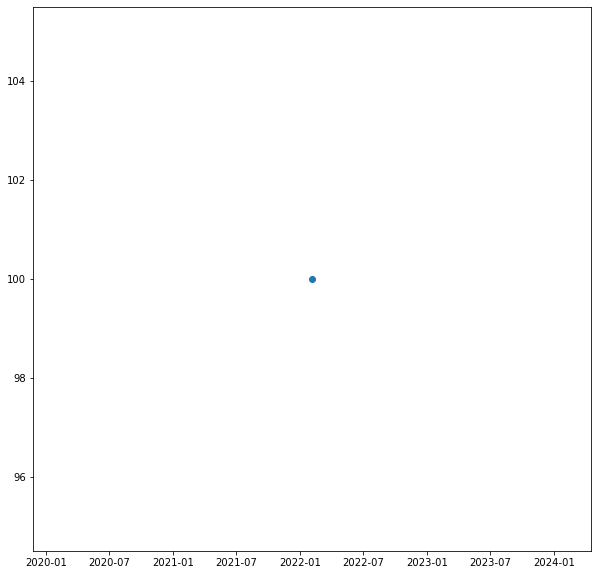

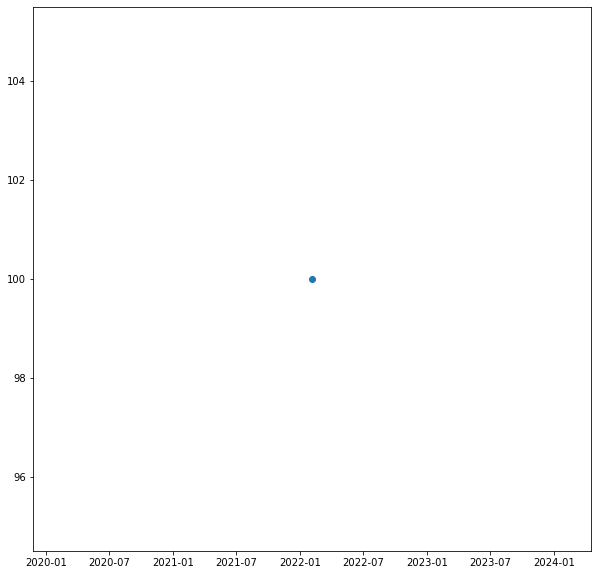

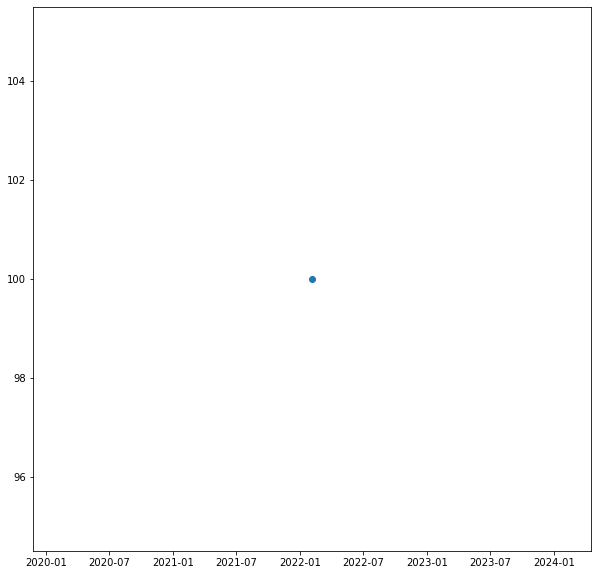

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

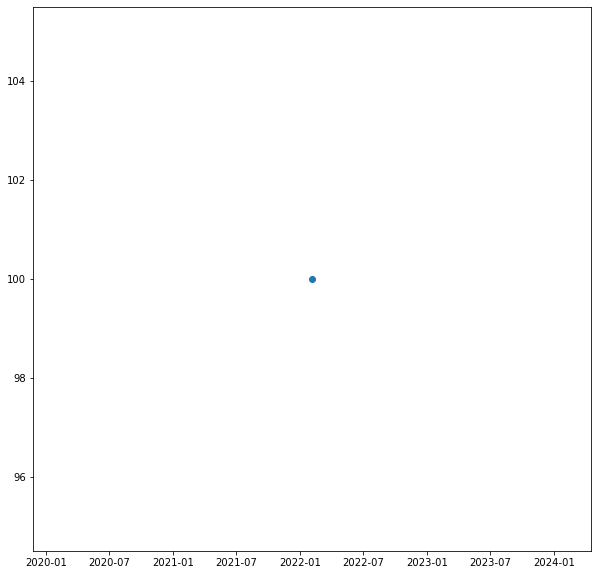

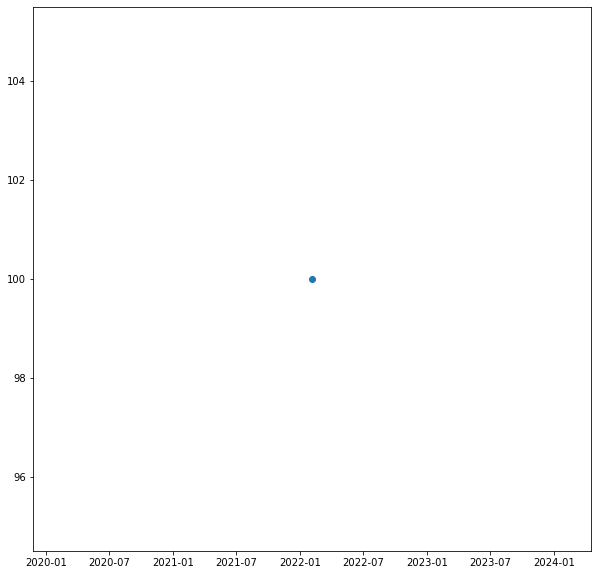

<Figure size 720x720 with 0 Axes>

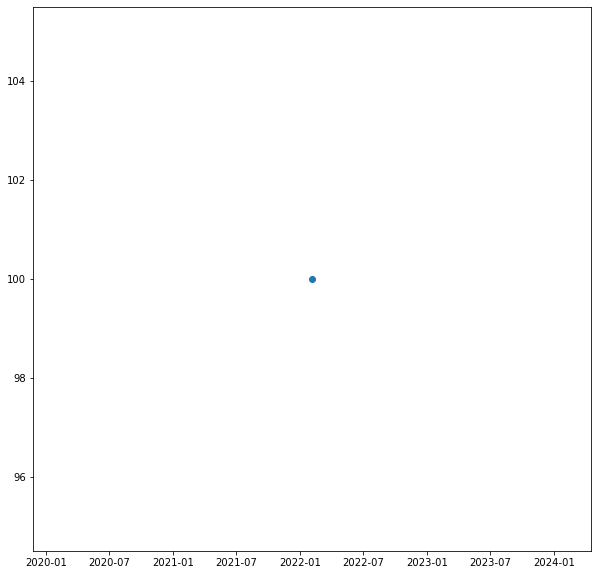

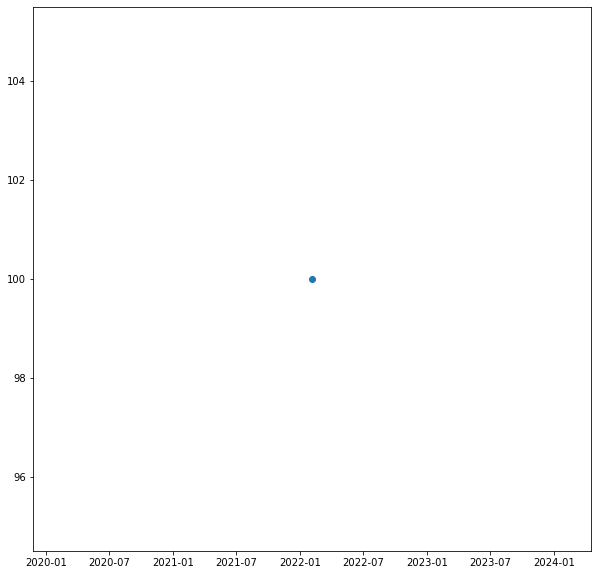

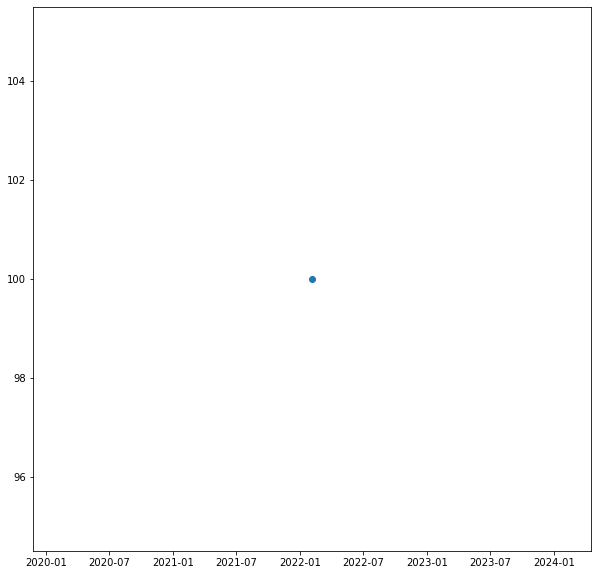

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

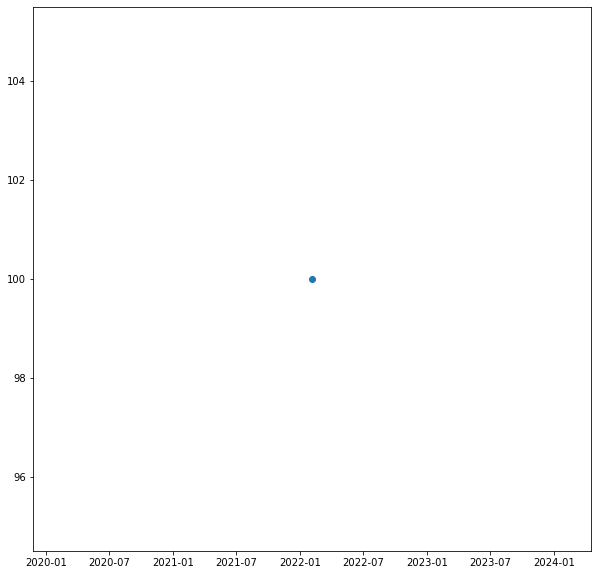

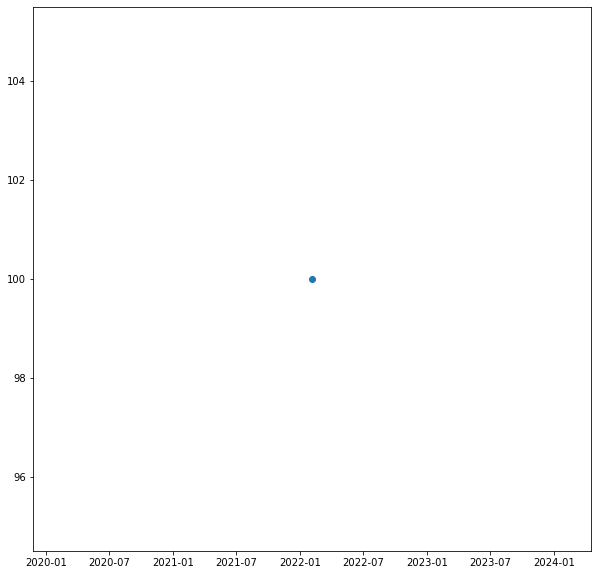

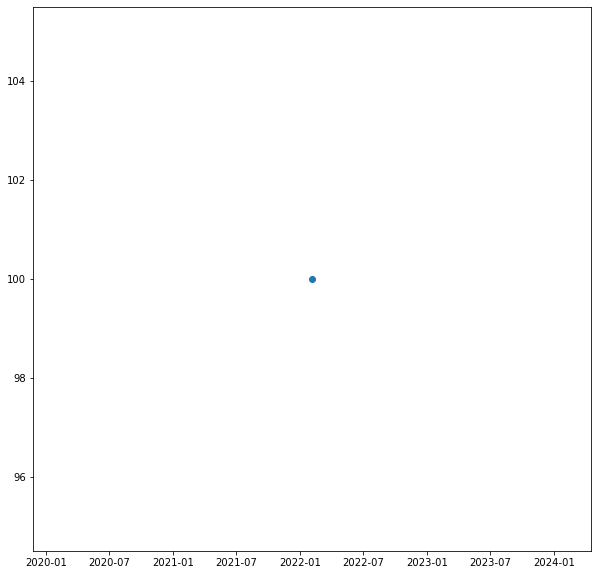

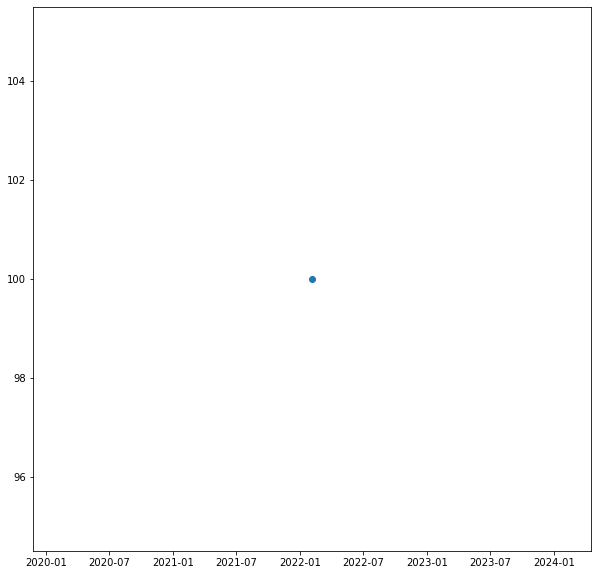

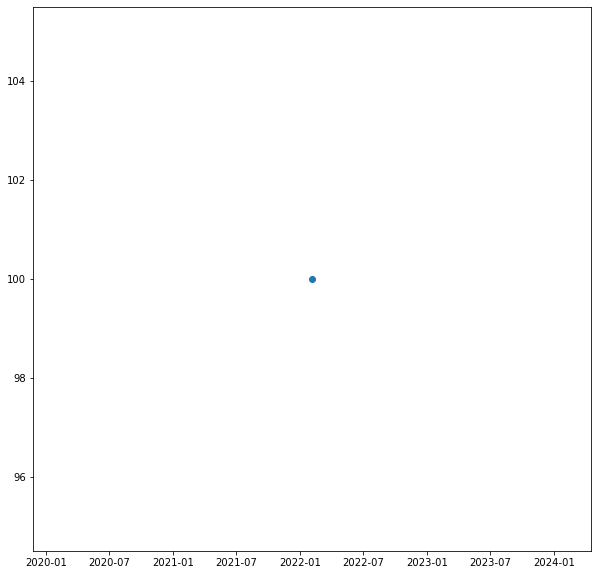

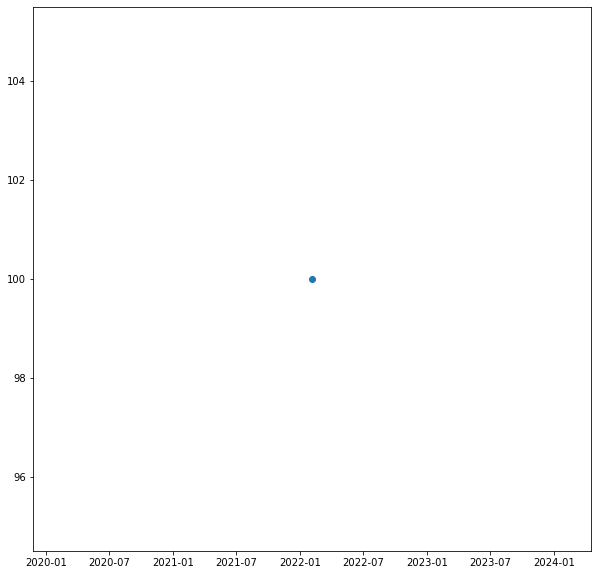

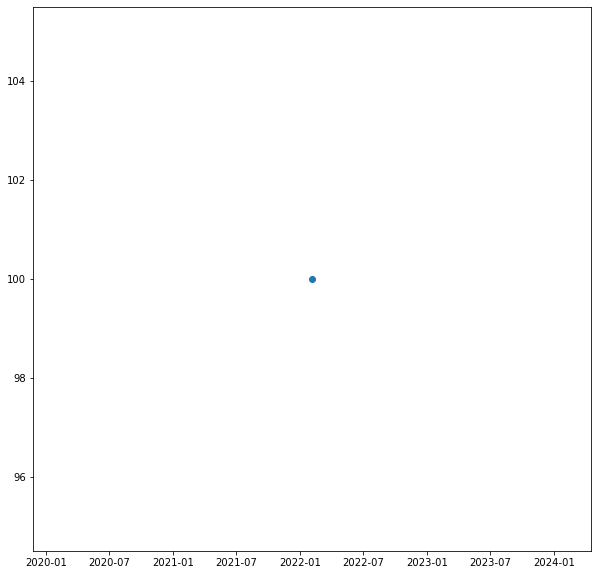

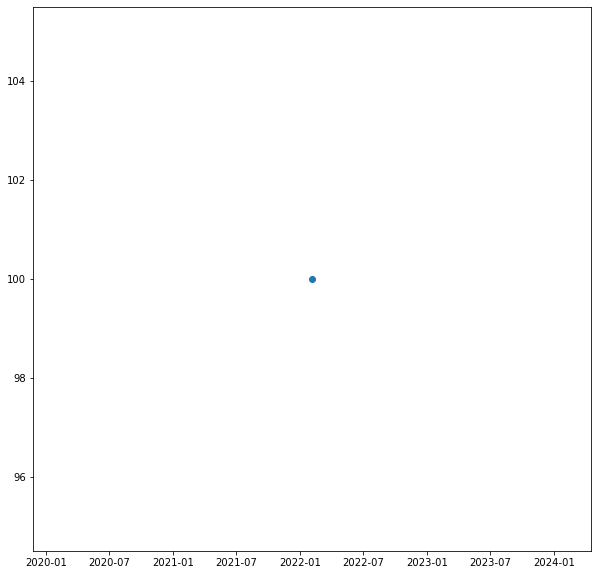

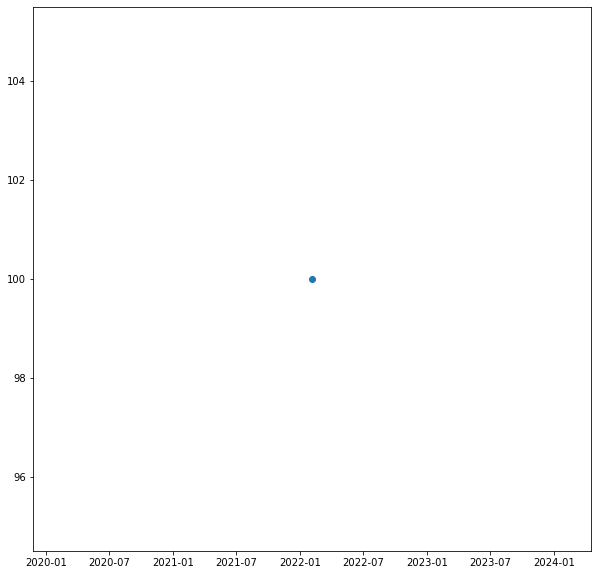

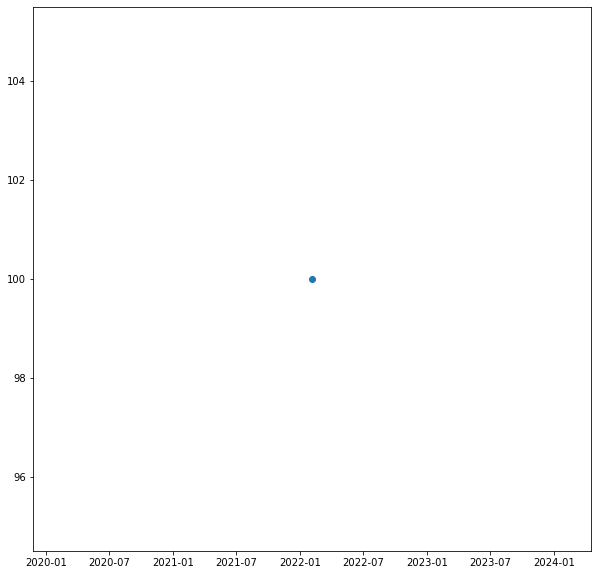

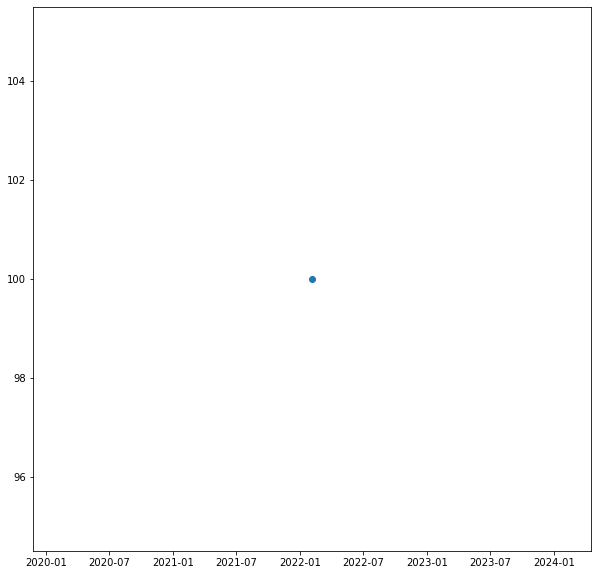

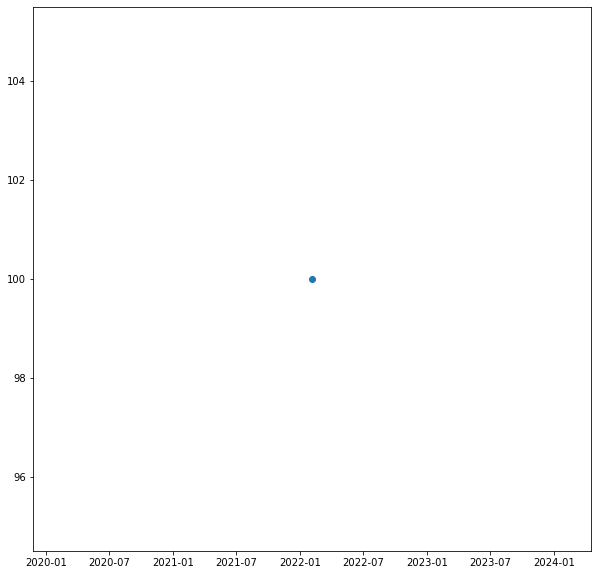

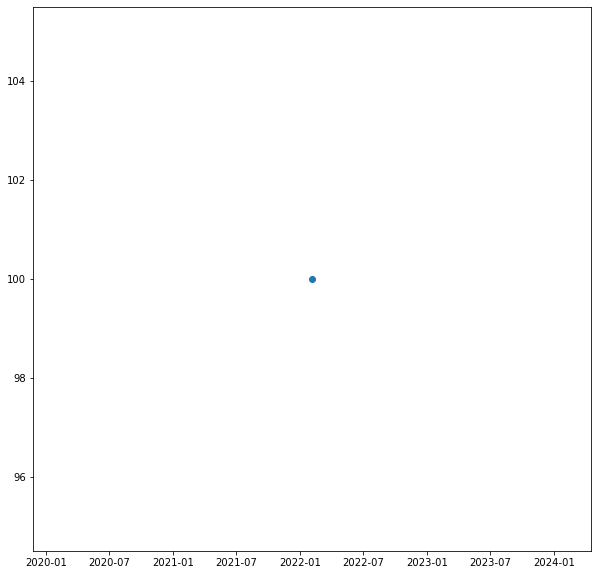

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

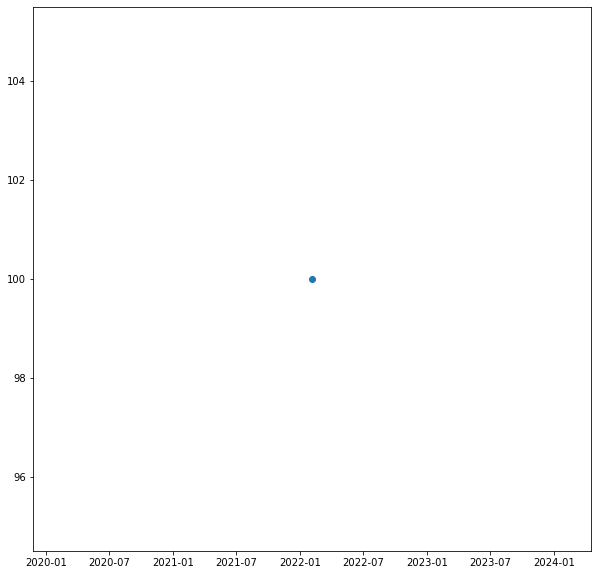

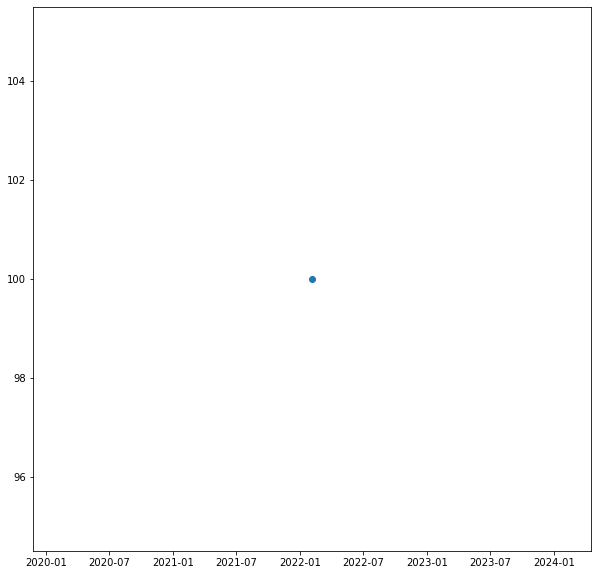

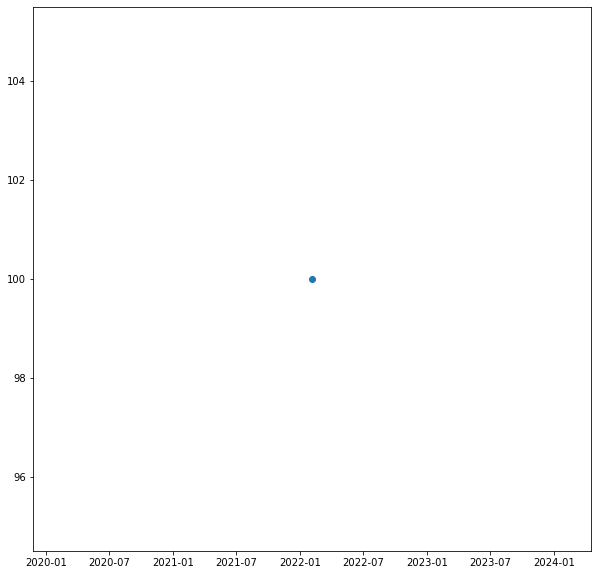

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

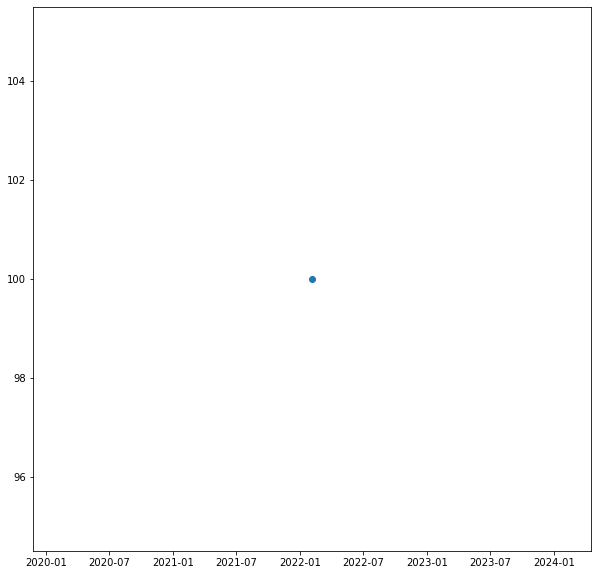

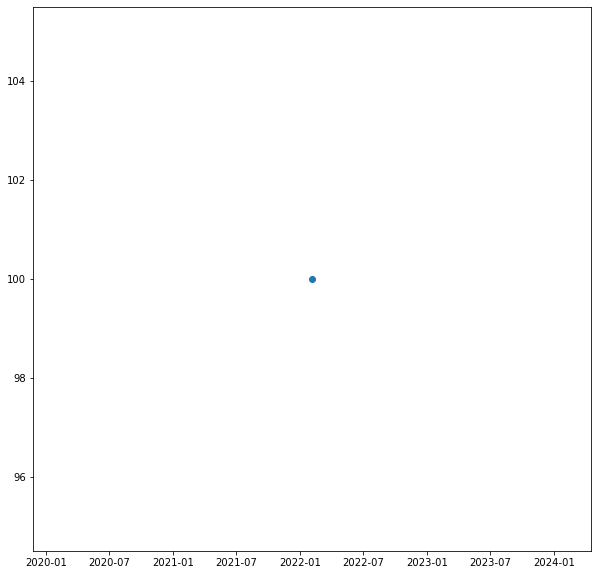

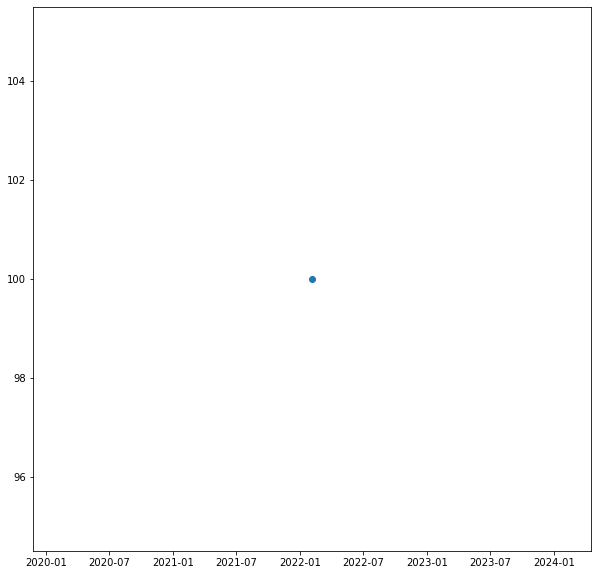

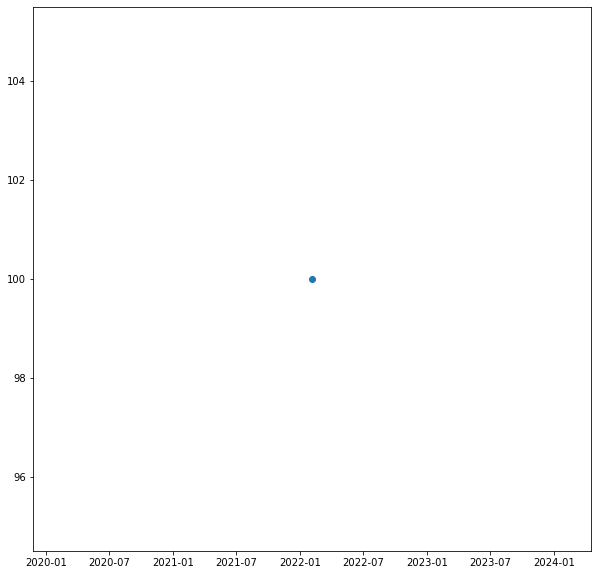

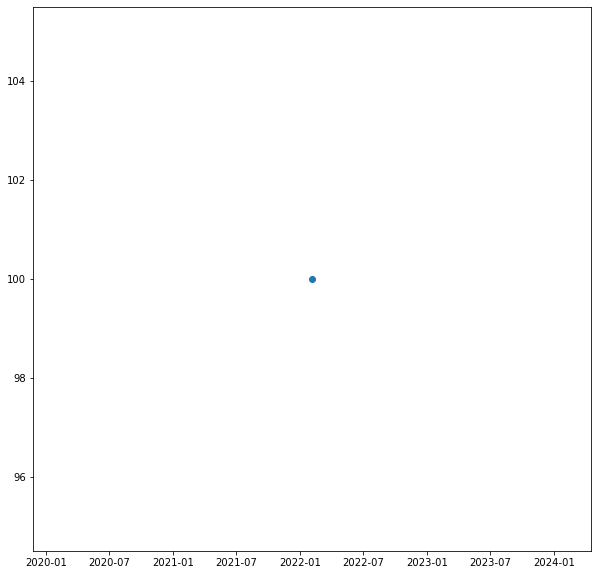

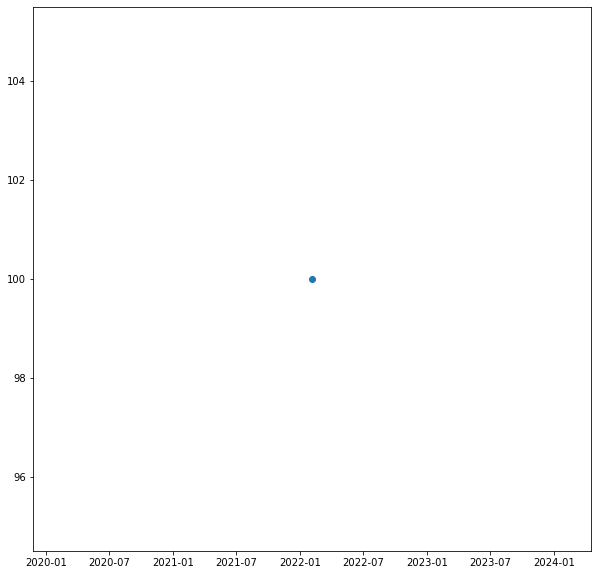

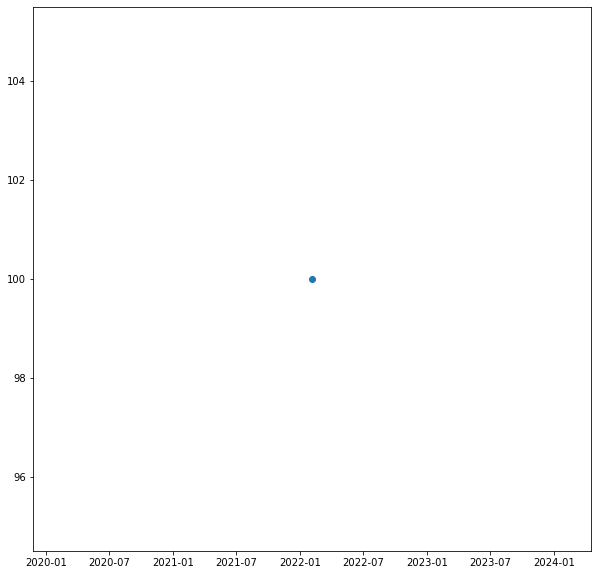

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

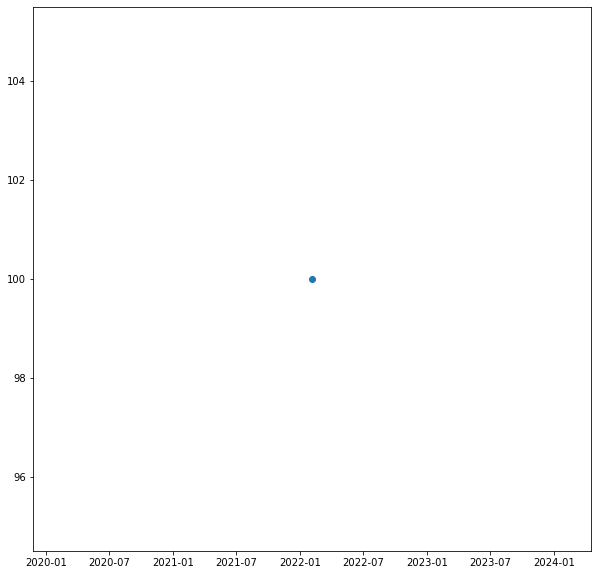

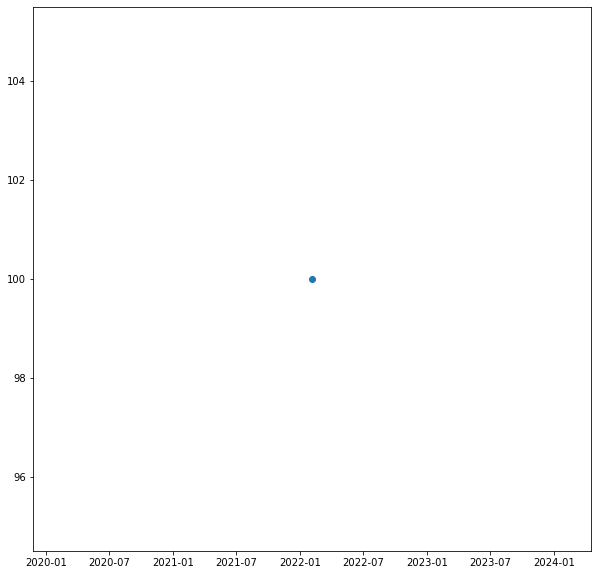

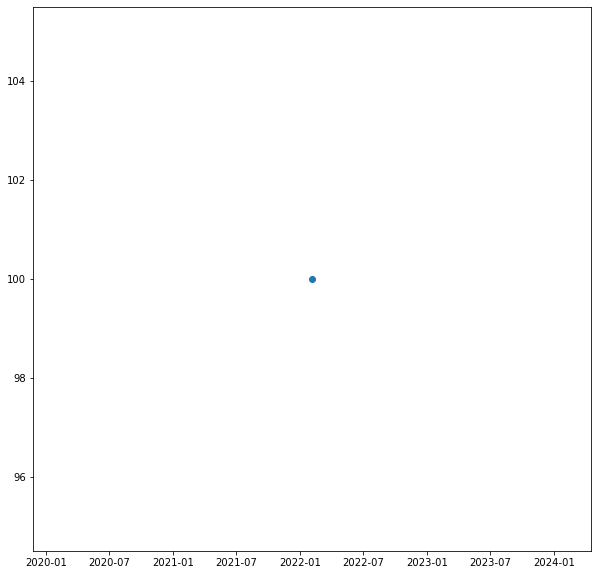

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

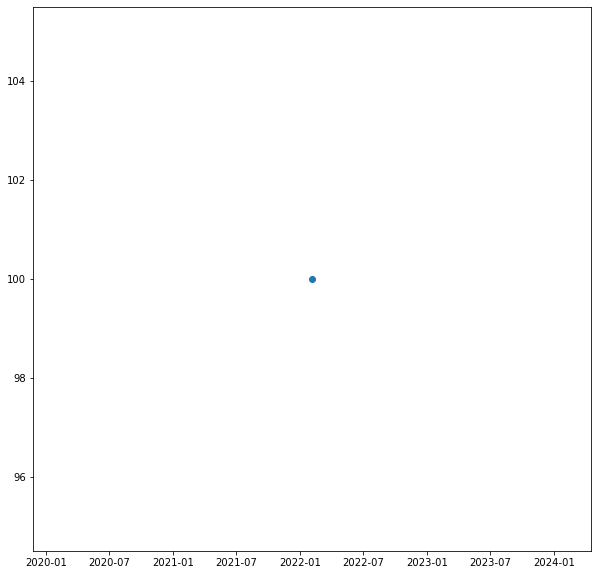

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

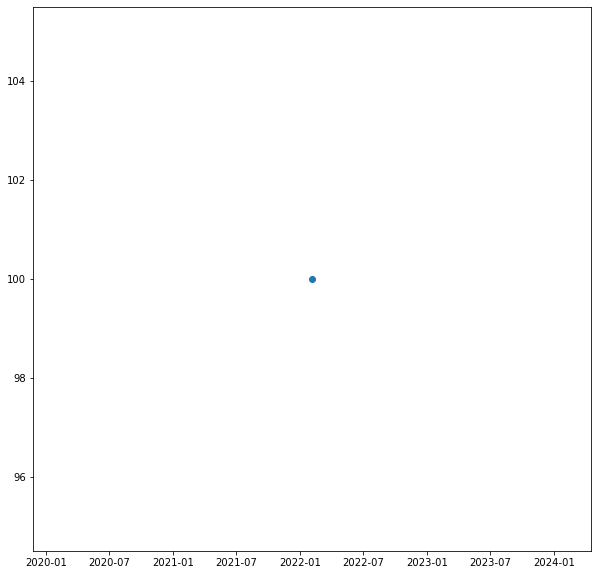

<Figure size 720x720 with 0 Axes>

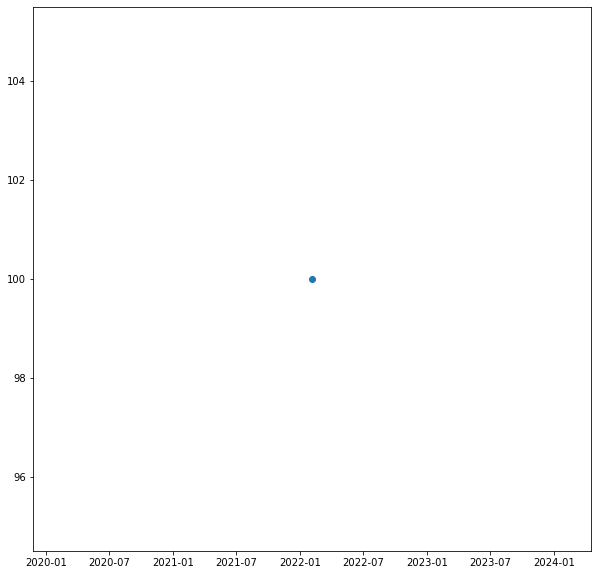

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

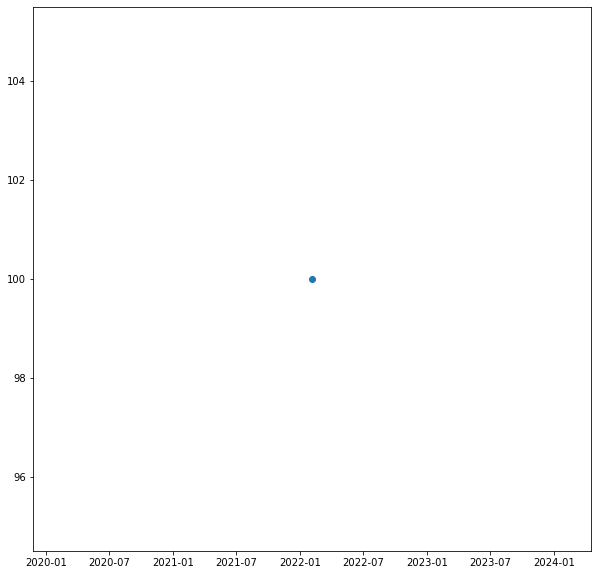

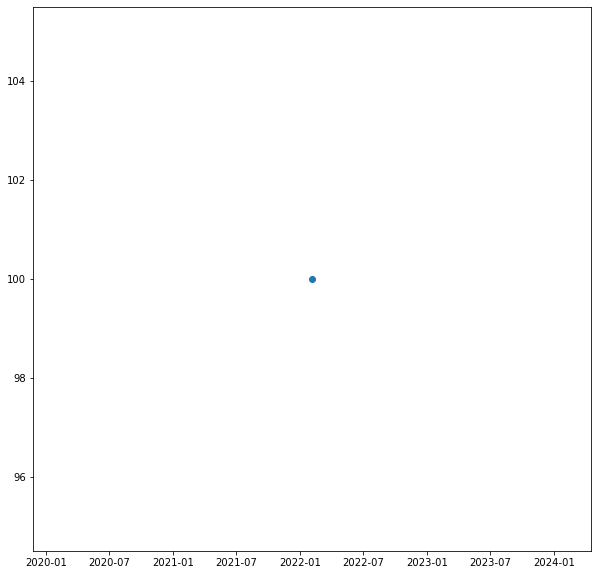

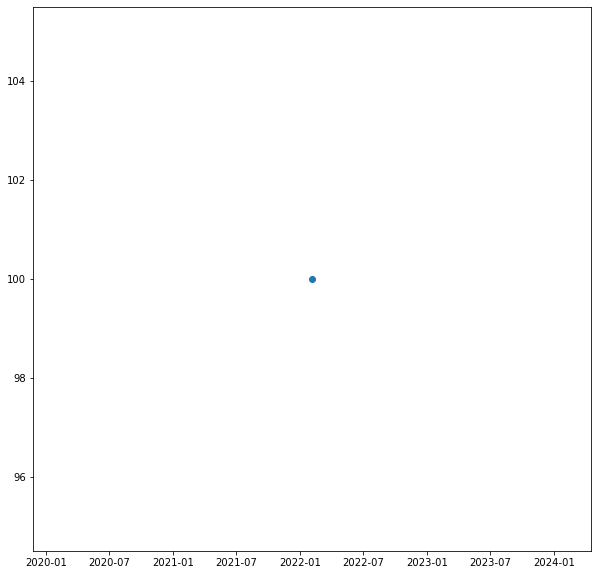

<Figure size 720x720 with 0 Axes>

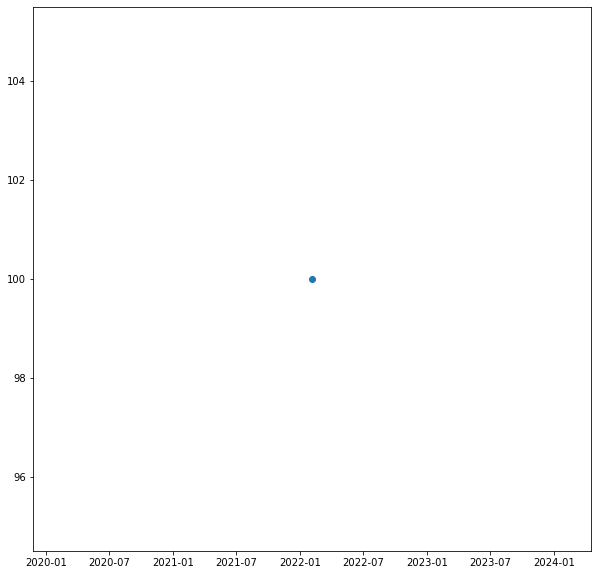

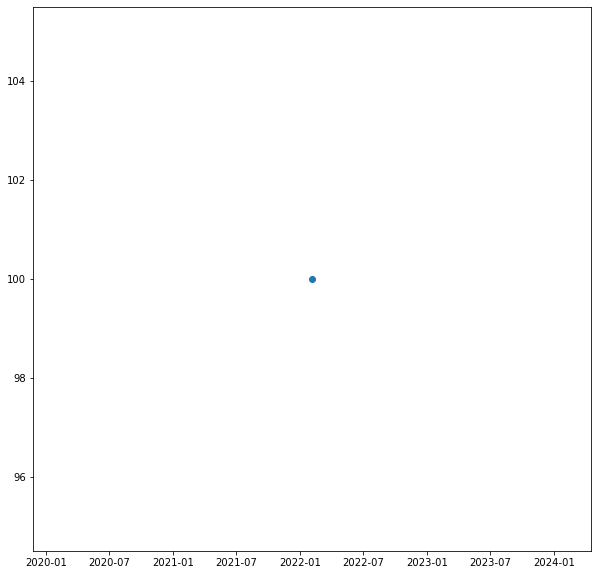

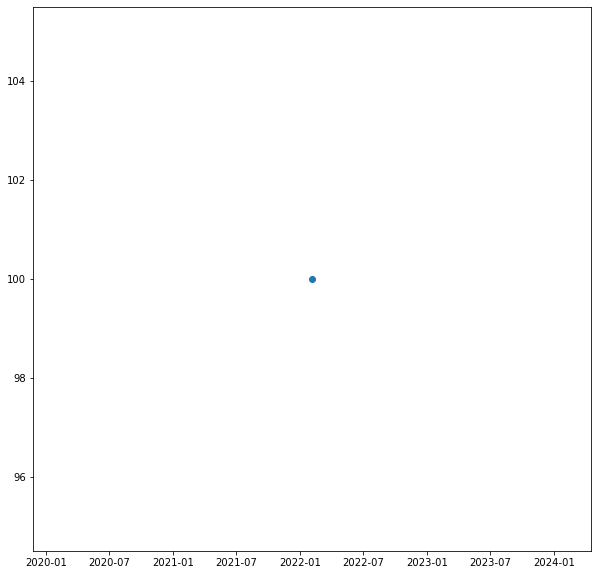

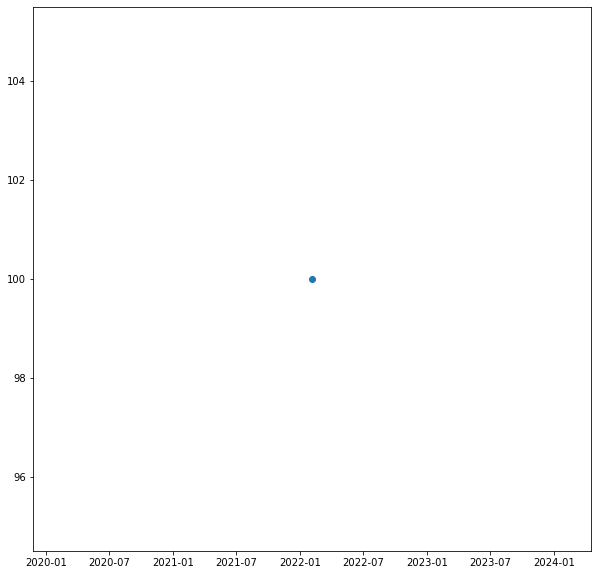

<Figure size 720x720 with 0 Axes>

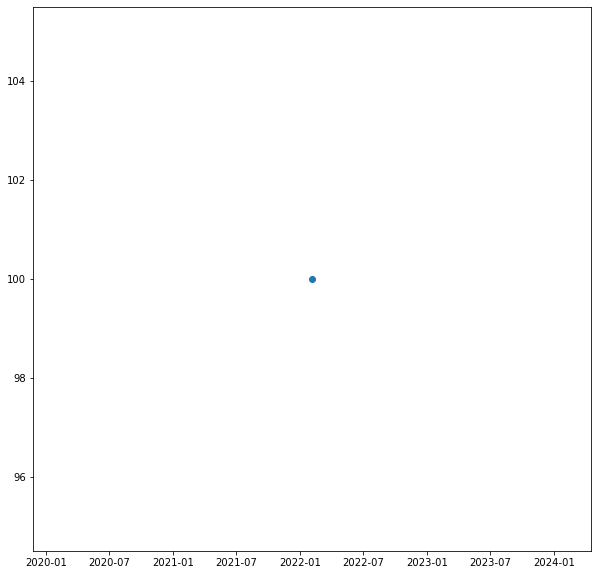

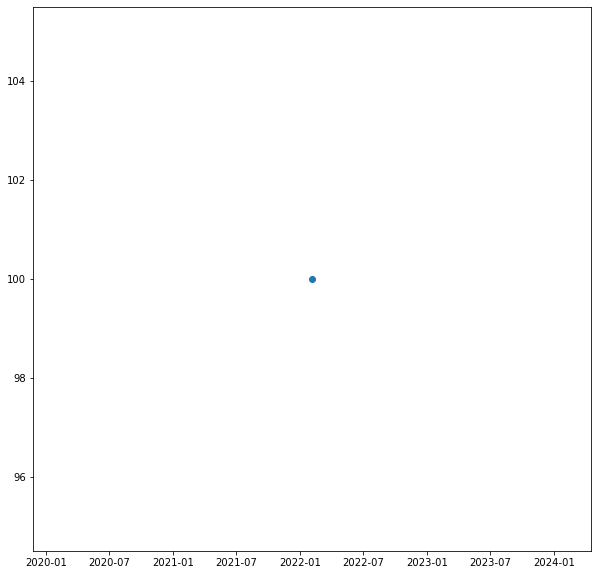

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

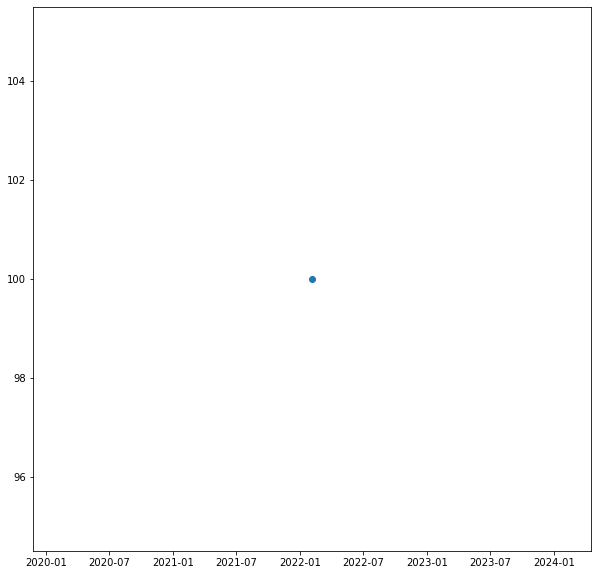

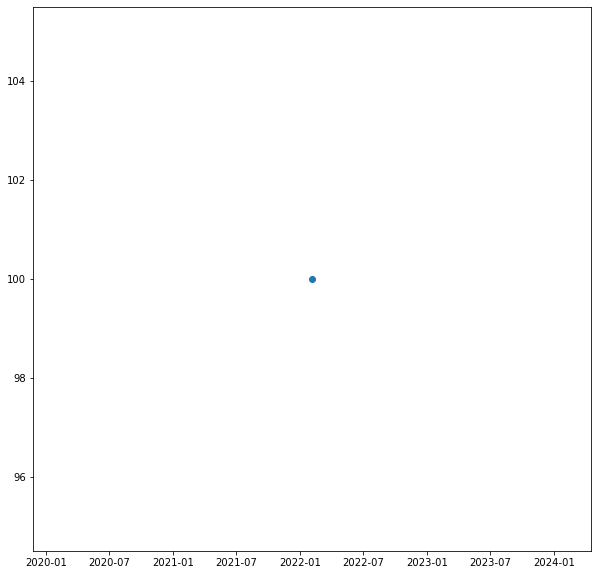

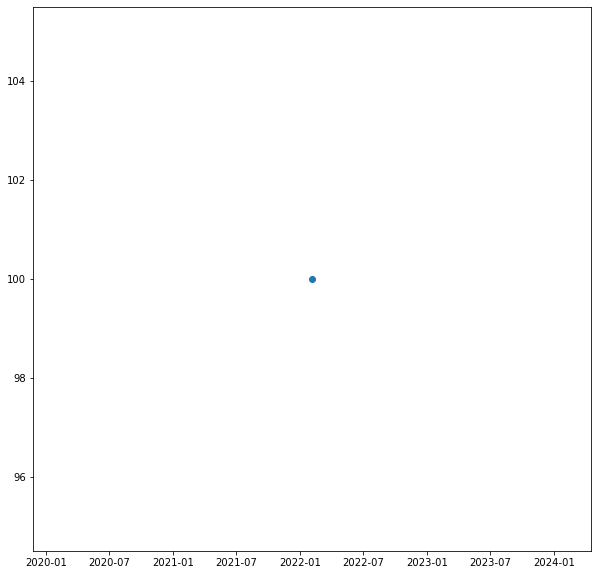

<Figure size 720x720 with 0 Axes>

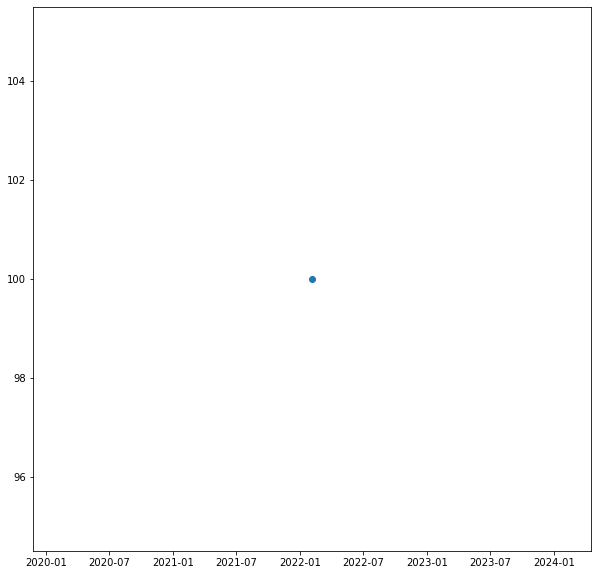

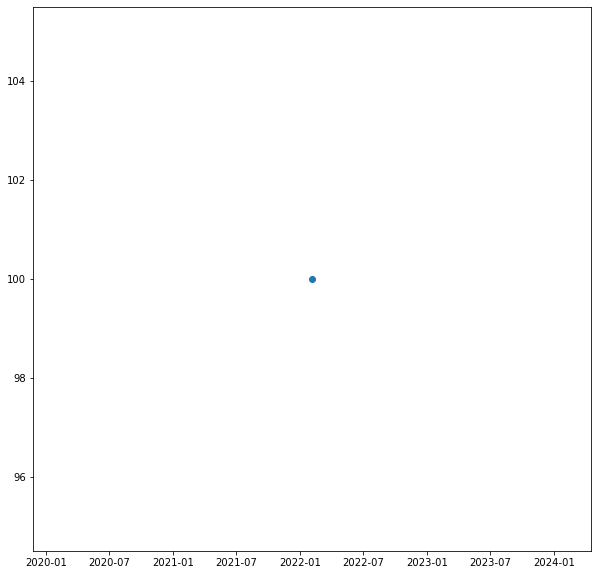

<Figure size 720x720 with 0 Axes>

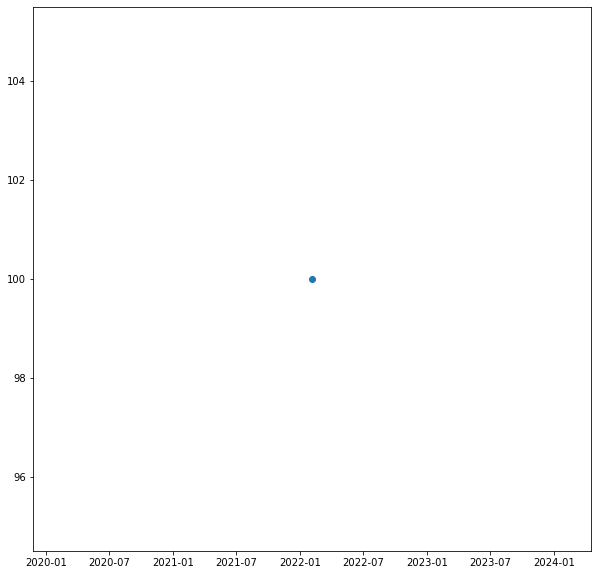

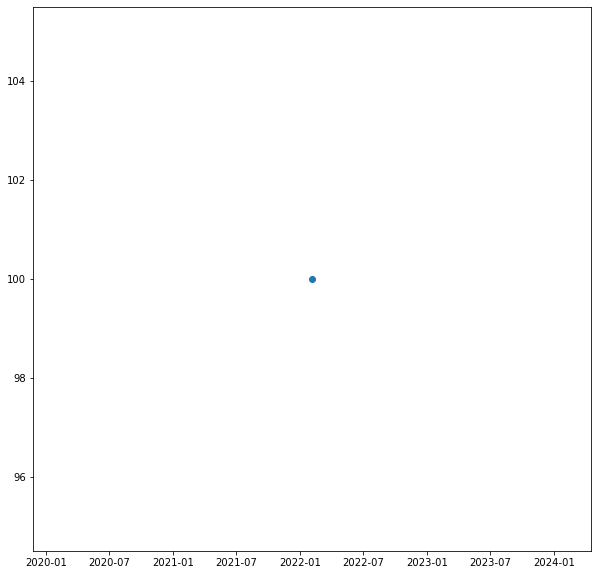

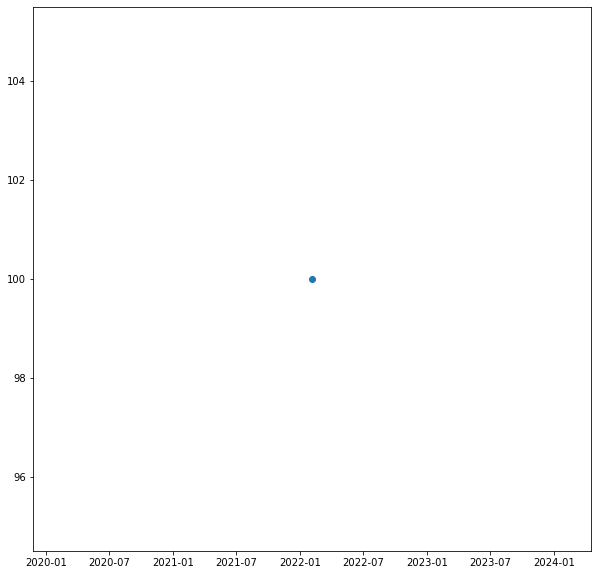

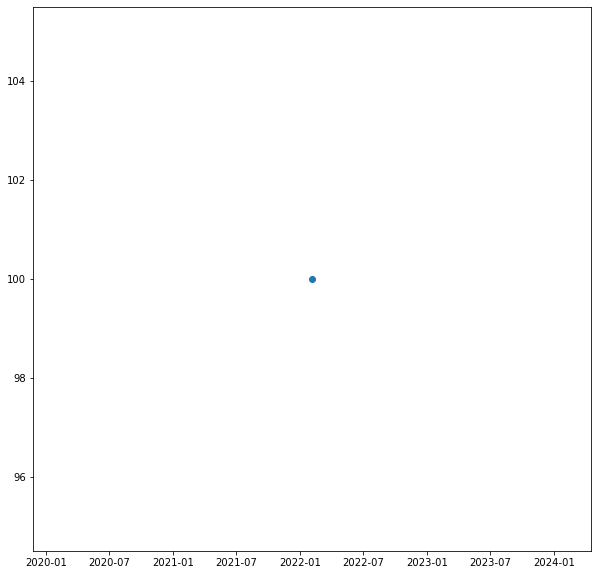

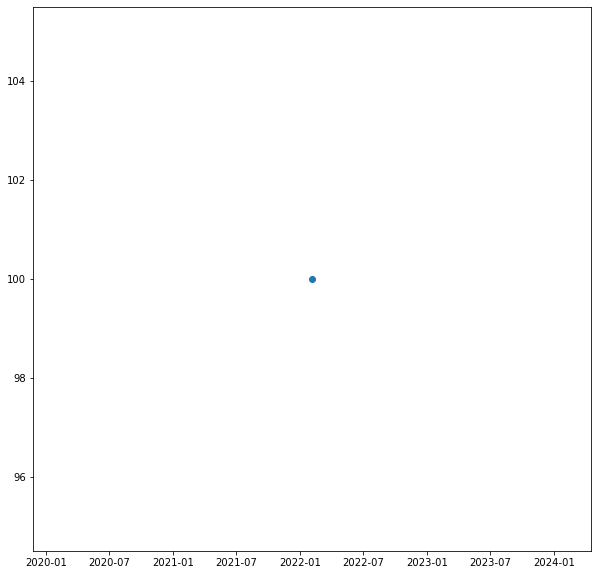

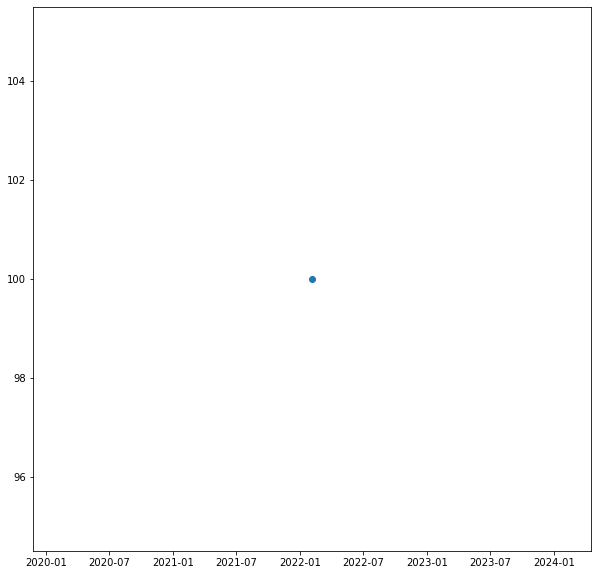

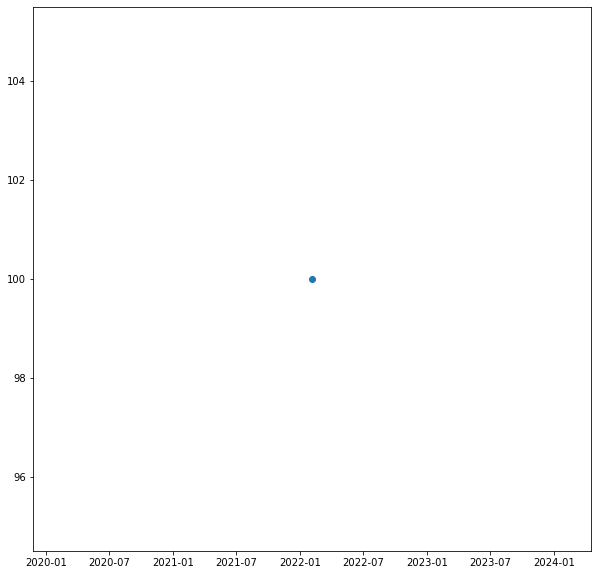

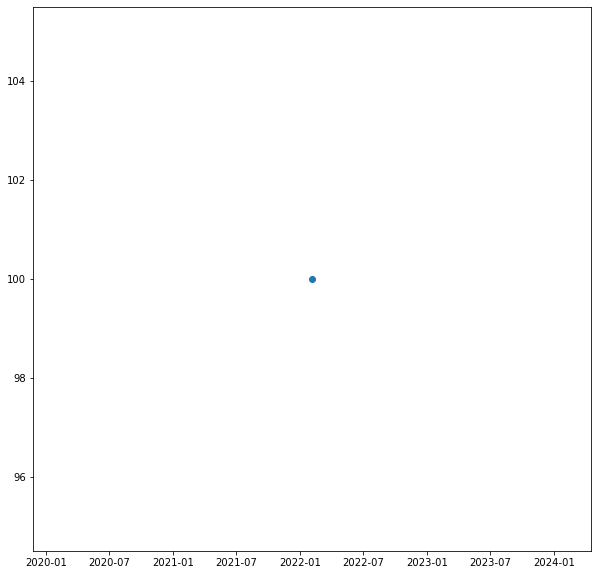

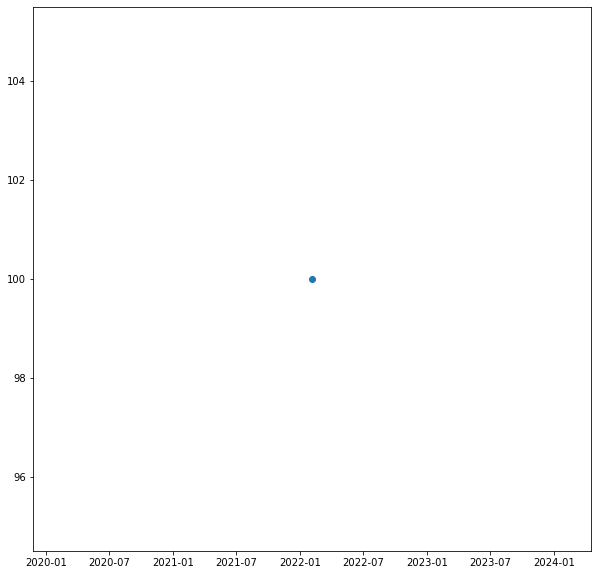

In [34]:
def xgClassifier(xTrain, xTest, yTrain, yTest):
    clf = xgb.XGBClassifier(scale_pos_weight=len(yTrain) / np.sum(yTrain), n_jobs=coreNumber, n_estimators=250, max_depth=3, objective="binary:logistic", eval_metric="error")
    clf.fit(xTrain, yTrain)

    predictionsTest = clf.predict_proba(xTest)
    predictionsTest = predictionsTest[:, 1]
    rocAuc = roc_auc_score(yTest, predictionsTest, average="weighted")

    # fpr, tpr, thresholds = roc_curve(yTest, predictionsTest, pos_label=1)
    # plt.xlabel("FPR")
    # plt.ylabel("TPR")
    # plt.title("ROC-AUC:" + str(np.round(roc_auc_score(yTest, predictionsTest,average='weighted'), 3)))
    # plt.scatter(fpr, tpr)
    # plt.plot([0, 0], [1, 1], color="red")
    # plt.show()

    predictionsTest = clf.predict(xTest)
    accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
    recall = sklearn.metrics.recall_score(yTest, predictionsTest)
    precision = sklearn.metrics.precision_score(yTest, predictionsTest)
    f1Score = sklearn.metrics.f1_score(yTest, predictionsTest, average="weighted")
    featureImportance = clf.feature_importances_
    statFeatureNames = [
        "-Range",
        "-Mean",
        "-STD",
        "-Min",
        "-Max",
        "-Skewness",
        "-Kurtosis",
        "-FirstFourthSlope",
        "-SecondFourthSlope",
        "-ThirdFourthSlope",
        "-FourthFourthSlope",
        "-HalvesSlope",
        "-RangeDiff",
        "-MeanDiff",
        "-STDDiff",
        "-MinDiff",
        "-MaxDiff",
        "-SkewnessDiff",
        "-KurtosisDiff",
        "-FirstFourthSlopeDiff",
        "-SecondFourthSlopeDiff",
        "-ThirdFourthSlopeDiff",
        "-FourthFourthSlopeDiff",
        "-HalvesSlopeDiff",
    ]
    featureImportance = dict(zip(statFeatureNames, featureImportance))

    return [rocAuc, accuracy, recall, precision, f1Score, np.sum(yTest), len(yTest) - np.sum(yTest), featureImportance, yTest, predictionsTest]


def lrClassifier(xTrain, xTest, yTrain, yTest):
    clf = LogisticRegression(random_state=0, class_weight="balanced", n_jobs=coreNumber)
    clf.fit(xTrain, yTrain)

    predictionsTest = clf.predict_proba(xTest)
    predictionsTest = predictionsTest[:, 1]
    rocAuc = roc_auc_score(yTest, predictionsTest, average="weighted")

    # fpr, tpr, thresholds = roc_curve(yTest, predictionsTest, pos_label=1)
    # plt.xlabel("FPR")
    # plt.ylabel("TPR")
    # plt.title("ROC-AUC:" + str(np.round(roc_auc_score(yTest, predictionsTest,average='weighted'), 3)))
    # plt.scatter(fpr, tpr)
    # plt.plot([0, 0], [1, 1], color="red")
    # plt.show()

    predictionsTest = clf.predict(xTest)

    accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
    recall = sklearn.metrics.recall_score(yTest, predictionsTest)
    precision = sklearn.metrics.precision_score(yTest, predictionsTest)
    f1Score = sklearn.metrics.f1_score(yTest, predictionsTest, average="weighted")
    featureImportance = clf.coef_
    featureImportance = featureImportance[0]
    statFeatureNames = [
        "-Range",
        "-Mean",
        "-STD",
        "-Min",
        "-Max",
        "-Skewness",
        "-Kurtosis",
        "-FirstFourthSlope",
        "-SecondFourthSlope",
        "-ThirdFourthSlope",
        "-FourthFourthSlope",
        "-HalvesSlope",
        "-RangeDiff",
        "-MeanDiff",
        "-STDDiff",
        "-MinDiff",
        "-MaxDiff",
        "-SkewnessDiff",
        "-KurtosisDiff",
        "-FirstFourthSlopeDiff",
        "-SecondFourthSlopeDiff",
        "-ThirdFourthSlopeDiff",
        "-FourthFourthSlopeDiff",
        "-HalvesSlopeDiff",
    ]
    featureImportance = dict(zip(statFeatureNames, featureImportance))
    return [rocAuc, accuracy, recall, precision, f1Score, np.sum(yTest), len(yTest) - np.sum(yTest), featureImportance, yTest, predictionsTest]


def rfClassifier(xTrain, xTest, yTrain, yTest):
    clf = RandomForestClassifier(max_depth=3, random_state=0, n_jobs=coreNumber, class_weight="balanced")
    clf.fit(xTrain, yTrain)

    predictionsTest = clf.predict_proba(xTest)
    predictionsTest = predictionsTest[:, 1]
    rocAuc = roc_auc_score(yTest, predictionsTest, average="weighted")

    # fpr, tpr, thresholds = roc_curve(yTest, predictionsTest, pos_label=1)
    # plt.xlabel("FPR")
    # plt.ylabel("TPR")
    # plt.title("ROC-AUC:" + str(np.round(roc_auc_score(yTest, predictionsTest,average='weighted'), 3)))
    # plt.scatter(fpr, tpr)
    # plt.plot([0, 0], [1, 1], color="red")
    # plt.show()

    predictionsTest = clf.predict(xTest)

    accuracy = sklearn.metrics.accuracy_score(yTest, predictionsTest)
    recall = sklearn.metrics.recall_score(yTest, predictionsTest)
    precision = sklearn.metrics.precision_score(yTest, predictionsTest)
    f1Score = sklearn.metrics.f1_score(yTest, predictionsTest, average="weighted")
    featureImportance = clf.feature_importances_
    statFeatureNames = [
        "-Range",
        "-Mean",
        "-STD",
        "-Min",
        "-Max",
        "-Skewness",
        "-Kurtosis",
        "-FirstFourthSlope",
        "-SecondFourthSlope",
        "-ThirdFourthSlope",
        "-FourthFourthSlope",
        "-HalvesSlope",
        "-RangeDiff",
        "-MeanDiff",
        "-STDDiff",
        "-MinDiff",
        "-MaxDiff",
        "-SkewnessDiff",
        "-KurtosisDiff",
        "-FirstFourthSlopeDiff",
        "-SecondFourthSlopeDiff",
        "-ThirdFourthSlopeDiff",
        "-FourthFourthSlopeDiff",
        "-HalvesSlopeDiff",
    ]
    featureImportance = dict(zip(statFeatureNames, featureImportance))
    return [rocAuc, accuracy, recall, precision, f1Score, np.sum(yTest), len(yTest) - np.sum(yTest), featureImportance, yTest, predictionsTest]


def testTrainSplit(dfParticipant, participant, combination, normalFlag):
    dfParticipant.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)

    yDataBinary = dfParticipant["MealLabel"].to_list()
    yDataBinary = np.asarray(yDataBinary).astype(int)
    timingInfo = dfParticipant[["StartTime", "FinishTime", "MealStartList", "MealEndList"]].values
    dfParticipant.drop(columns=["StartTime", "FinishTime", "MealLabel", "Participant", "Carb", "Fat", "Protein", "MealStartList", "MealEndList"], inplace=True)

    xDataBinary = dfParticipant.values
    xDataBinary = np.asarray(xDataBinary).astype(float)

    classifierReport = []
    if normalFlag:
        xDataBinary -= np.mean(xDataBinary, axis=0)
        xDataBinary /= np.std(xDataBinary, axis=0)

    skf = StratifiedKFold(n_splits=5, shuffle=False)
    setNumber = 0
    comprehensive = []
    for trainIndex, testIndex in skf.split(xDataBinary, yDataBinary):
        xTrain, xTest = xDataBinary[trainIndex, :], xDataBinary[testIndex, :]
        yTrain, yTest = yDataBinary[trainIndex], yDataBinary[testIndex]

        timingInfoTest = timingInfo[testIndex, :]
        comprehensiveCGM = []
        for element in timingInfoTest:
            dfCGMTemp = dfCGM[dfCGM["Participant"] == participant]
            dfCGMTemp = dfCGMTemp[dfCGMTemp["Time"] >= element[0]]
            dfCGMTemp = dfCGMTemp[dfCGMTemp["Time"] < element[1]]
            comprehensiveCGM.append(dfCGMTemp["Abbot"].to_list())

        tempListReport = xgClassifier(xTrain, xTest, yTrain, yTest)
        # tempListReport = lrClassifier(xTrain, xTest, yTrain, yTest)
        # tempListReport = rfClassifier(xTrain, xTest, yTrain, yTest)

        tempListReport.extend([participant, combination, setNumber])
        classifierReport.append(tempListReport)

        comprehensiveCGM = np.asarray(comprehensiveCGM)
        comprehensiveCGM = np.concatenate((comprehensiveCGM, timingInfoTest), axis=1)

        predVal = tempListReport[-4]
        groundTruthVal = tempListReport[-5]

        predVal = np.asarray(predVal)
        groundTruthVal = np.asarray(groundTruthVal)

        predVal = np.expand_dims(predVal, axis=1)
        groundTruthVal = np.expand_dims(groundTruthVal, axis=1)
        tempArray=np.repeat(participant,len(predVal))
        tempArray=np.expand_dims(tempArray,axis=1)
        comprehensiveCGM = np.concatenate((comprehensiveCGM, groundTruthVal,predVal,tempArray), axis=1)
        if len(comprehensive) == 0:
            comprehensive = comprehensiveCGM
        else:
            comprehensive = np.concatenate((comprehensive, comprehensiveCGM), axis=0)

        setNumber += 1
    comprehensiveHeaders=[]
    for counter in range(60):
        comprehensiveHeaders.append("CGM-"+str(counter))
    comprehensiveHeaders.extend(["WindowStart","WindowEnd","MealStart","MealEnd","Truth","Pred","Participant"])    
    comprehensive=pd.DataFrame(comprehensive,columns=comprehensiveHeaders)
    # comprehensive.to_excel(os.path.join(addResults,"comprehensive.xlsx"))
    mealStartTemp=comprehensive["MealStart"].iloc[counter]
    for counter in range(len(comprehensive)):
        if comprehensive["Truth"].iloc[counter]==comprehensive["Pred"].iloc[counter]:
            continue
        plt.figure(figsize=(10,10))
        if len(comprehensive["MealStart"].iloc[counter])==0:
            myColor='red'
        else:

            plt.scatter(mealStartTemp[0],100)
            myColor='blue'
            # print(comprehensive["WindowStart"].iloc[counter],comprehensive["WindowEnd"].iloc[counter],comprehensive["MealStart"].iloc[counter])
        # xVals=[]
        # for minuteCounter in range(60):
        #     xVals.append(comprehensive["WindowStart"].iloc[counter]+timedelta(minutes=minuteCounter))
        # xVals=np.asarray(xVals)

        # yVals=comprehensive.iloc[counter,0:60].values
        # yVals=np.asarray(yVals)
        
        # plt.plot(xVals,yVals,color=myColor)

        # plt.ylim([60,160])
        # plt.show()

    raise

    return classifierReport


def predictionMain(dfCombination, randomSeed, normalFlag, combination):
    participants = list(set(dfCombination["Participant"].to_list()))
    classifierReports = []
    # for participantCounter in tqdm(range(len(participants) + 1)):
    for participantCounter in range(len(participants)):
        if participantCounter == len(participants):  # General Model (one model for all participants)
            dfParticipant = dfCombination
            participant = "All"
        else:  # Personal Model (each participant have a his/her own model)
            participant = participants[participantCounter]
            dfParticipant = dfCombination[dfCombination["Participant"] == participant]
        dfParticipant.sort_values(["Participant", "StartTime"], ascending=(True, True), inplace=True)
        print("*************************", "Participant:", participant)
        classifierReports.extend(testTrainSplit(dfParticipant, participant, combination, normalFlag))
    return classifierReports


def featureImportanceAverager(featureImportances):
    tempVals = []
    tempLabels = []
    for featureImportance in featureImportances:
        tempVals.append(list(featureImportance.values()))
        tempLabels = list(featureImportance.keys())
    featureImportances = np.asarray(tempVals)
    featureImportances = np.mean(featureImportances, axis=0)
    featureImportances = dict(zip(tempLabels, featureImportances))
    featureImportances = dict(sorted(featureImportances.items(), key=lambda item: item[1], reverse=True))
    featureImportances = [[featureImportances]]
    return featureImportances


def foldSummarizerBinary(df):
    combinations = list(set(df["Combination"].to_list()))
    participants = list(set(df["Participant"].to_list()))
    participants.sort()
    dfSummarizeds = []
    headers = ["Participant", "Combination", "ROC-AUC", "Accuracy", "Recall", "Precision", "F1", "TestPositive", "TestNegative", "SetNumber", "FeatureImportance"]
    for participant in participants:
        for combination in combinations:
            dfSummarized = [participant, combination]
            dfTemp = df[(df["Participant"] == participant) & (df["Combination"] == combination)]
            assert len(dfTemp) == FOLD_NUMBER
            featureImportances = dfTemp["FeatureImportance"].to_list()
            featureImportances = featureImportanceAverager(featureImportances)
            dfTemp.drop(columns=["FeatureImportance"], inplace=True)
            dfSummarized.extend(dfTemp.mean())
            dfSummarized.extend(featureImportances)
            dfSummarizeds.append(dfSummarized)
    dfSummarizeds = pd.DataFrame(dfSummarizeds, columns=headers)
    dfSummarizeds.drop(columns=["SetNumber"], inplace=True)
    dfSummarizeds.sort_values(["Participant", "Combination"], ascending=(True, True), inplace=True)
    dfSummarizeds.to_excel(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier-Summary.xlsx"),), index=False)

    print("Outter:", str(OUTTER_WINDOW_LENGTH), "Fasting:", str(FASTING_LENGTH))
    print(("---------------------------------------------------------"))

    return dfSummarizeds


if os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx"))):
    os.remove(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")))
if not os.path.exists(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx"))):
    dfAllFeaturesHoover = pd.read_pickle(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-All-Features-AfterHoover.pkl")))
    dfAllFeaturesHoover = dfAllFeaturesHoover.dropna()
    print("Total Number of Samples:", len(dfAllFeaturesHoover))
    combinations = [["CGM"], ["CM"], ["CGM", "CM"], ["CGM", "CM", "Temperature"], ["CGM", "CM", "Temperature", "HR", "EDA"]]
    combinations=[["CGM"]]###################CHANGE THIS!!!!!!!!!!!!!!!!!!
    columns = dfAllFeaturesHoover.columns
    headersClassifier = ["ROC-AUC", "Accuracy", "Recall", "Precision", "F1", "TestPositive", "TestNegative", "FeatureImportance", "Truth", "Predictions", "Participant", "Combination", "SetNumber"]
    dfClassifier = []
    for combination in combinations:
        columnList = ["StartTime", "FinishTime", "Participant", "Carb", "Fat", "Protein", "MealLabel", "MealStartList", "MealEndList"]
        for topic in combination:
            for column in columns:
                if topic in column:
                    columnList.append(column)
        dfCombination = dfAllFeaturesHoover[dfAllFeaturesHoover.columns.intersection(columnList)]

        randomSeed = 60
        print("----------------------")
        print("Combination:", "+".join(combination))
        NORMALIZED_FLAG = True
        classifierReport = predictionMain(dfCombination, randomSeed, NORMALIZED_FLAG, "+".join(combination))
        dfTempClassifier = pd.DataFrame(classifierReport, columns=headersClassifier)

        if len(dfClassifier) > 0:
            frames = [dfTempClassifier, dfClassifier]
            dfClassifier = pd.concat(frames)
        else:
            dfClassifier = dfTempClassifier

    dfClassifier.reset_index(drop=True, inplace=True)
    dfClassifier.to_excel(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")), index=False)
else:
    dfClassifier = pd.read_excel(os.path.join(addResults, (str(OUTTER_WINDOW_LENGTH) + "-" + str(FASTING_LENGTH) + "-Final-Classifier.xlsx")))
dfSummarizeds = foldSummarizerBinary(dfClassifier)


In [ ]:
os.chdir(os.path.join(addResults))


def summaryPlotter(participant, metricType):
    metricCMList = []
    metricCGMList = []
    metricCGMCMList = []
    metricCGMCMTempList = []
    metricCGMCMTempHREDAList = []
    windowLenList = []
    for root, dirs, files in os.walk(os.path.join(addResults)):
        for file in sorted(files):
            if ".xlsx" in file.lower() and "summary" in file.lower() and "classifier" in file.lower():
                windowLen = file[: file.find("-")]

                dfTemp = pd.read_excel(file)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CM")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCMList.append(metricVal)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMList.append(metricVal)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM+CM")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMCMList.append(metricVal)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM+CM+Temperature")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMCMTempList.append(metricVal)

                metricVal = dfTemp[(dfTemp["Participant"] == participant) & (dfTemp["Combination"] == "CGM+CM+Temperature+HR+EDA")]
                metricVal = metricVal[metricType].to_list()
                assert len(metricVal) == 1
                metricVal = metricVal[0]
                metricCGMCMTempHREDAList.append(metricVal)
                windowLenList.append(windowLen)

    for counter in range(len(windowLenList)):
        tempVal = datetime.strptime(windowLenList[counter], "%H:%M:%S")
        tempVal = tempVal.time().hour * 60 + tempVal.time().minute
        windowLenList[counter] = tempVal
    return metricCMList, metricCGMList, metricCGMCMList, metricCGMCMTempList, metricCGMCMTempHREDAList, windowLenList


def metricPlotter(metricName):
    participants = ["p1", "p3", "p5", "p6", "p7", "p8"]
    subplotCounter = 1
    fig = plt.figure(figsize=(10, 15))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    for participant in participants:
        metricCMList, metricCGMList, metricCGMCMList, metricCGMCMTempList, metricCGMCMTempHREDAList, windowLenList = summaryPlotter(participant, metricName)
        slopeCGM, interceptCGM, r_valueCGM, p_valueCGM, std_errCGM = linregress(windowLenList, metricCGMList)
        slopeCM, interceptCM, r_valueCM, p_valueCM, std_errCM = linregress(windowLenList, metricCMList)
        slopeCGMCM, interceptCGMCM, r_valueCGMCM, p_valueCGMCM, std_errCGMCM = linregress(windowLenList, metricCGMCMList)

        print(participant, (30 * slopeCGM + interceptCGM - interceptCGMCM) / slopeCGMCM)
        # print(participant,slopeCGM,slopeCGMCM)
        # print(participant,interceptCGM,interceptCGMCM)

        plt.subplot(3, 2, subplotCounter)
        sns.regplot(x=windowLenList, y=metricCMList, marker="+", color=colors[0], label="CM")
        sns.regplot(x=windowLenList, y=metricCGMList, marker="s", color=colors[1], label="CGM")
        sns.regplot(x=windowLenList, y=metricCGMCMList, marker="d", color=colors[2], label="CGM+CM")
        # plt.plot(windowLenList, metricCGMCMTempList, "--o", color=colors[3], label="CGM+CM+Temperature")
        # plt.plot(windowLenList, metricCGMCMTempHREDAList, ":s", color=colors[4], label="CGM+CM+Temperature+HR+EDA")
        plt.text(20, 0.9, participant.capitalize())
        plt.ylim([0, 1])
        if subplotCounter == 3:
            plt.ylabel(metricName, labelpad=30)
        if subplotCounter == 5:
            # plt.xlabel("Window Length [min]",labelpad=30)
            frame1 = plt.gca()
            frame1.axes.set_xlabel("Window Length [min]", labelpad=30, x=1)
        if subplotCounter == 2:
            plt.legend(loc="upper right")
        if subplotCounter % 2 == 1:
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"])
        else:
            plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [])
        if subplotCounter >= 5:
            plt.xticks([15, 30, 45, 60, 75, 90], ["15", "30", "45", "60", "75", "90"])
        else:
            plt.xticks([15, 30, 45, 60, 75, 90], [])

        subplotCounter += 1

    fig.tight_layout()
    fig.savefig(os.path.join(addResults, "Eating-ROC-AUC Summary-" + metricName + "-" + str(FASTING_LENGTH) + ".jpg"), dpi=600)
    plt.show()


metricPlotter(metricName="Recall")
metricPlotter(metricName="Precision")


In [ ]:
# noNormal=[{'-MaxDiff': 0.1078463, '-SecondFourthSlopeDiff': 0.103150845, '-FourthFourthSlopeDiff': 0.07462696, '-ThirdFourthSlope': 0.06913031, '-Skewness': 0.056625057, '-SkewnessDiff': 0.050760787, '-STDDiff': 0.048788596, '-FirstFourthSlopeDiff': 0.046131063, '-RangeDiff': 0.04021073, '-HalvesSlopeDiff': 0.04018015, '-MinDiff': 0.033765636, '-HalvesSlope': 0.03357451, '-SecondFourthSlope': 0.033038698, '-FourthFourthSlope': 0.029650774, '-FirstFourthSlope': 0.02836506, '-Min': 0.025608739, '-Max': 0.024943182, '-STD': 0.024530888, '-Mean': 0.02407294, '-Range': 0.023151893, '-MeanDiff': 0.022112701, '-KurtosisDiff': 0.02190013, '-ThirdFourthSlopeDiff': 0.02160139, '-Kurtosis': 0.016232677},
# {'-MinDiff': 0.05836166, '-Max': 0.05825951, '-Mean': 0.056890287, '-FirstFourthSlopeDiff': 0.054751, '-SecondFourthSlope': 0.05199795, '-FirstFourthSlope': 0.051083237, '-RangeDiff': 0.047590412, '-FourthFourthSlopeDiff': 0.046937533, '-ThirdFourthSlope': 0.04655046, '-HalvesSlope': 0.044784807, '-Min': 0.043269206, '-SkewnessDiff': 0.042040505, '-MaxDiff': 0.041865278, '-HalvesSlopeDiff': 0.041717757, '-Skewness': 0.037697215, '-FourthFourthSlope': 0.034438096, '-MeanDiff': 0.03392487, '-STDDiff': 0.033244412, '-Range': 0.032868195, '-SecondFourthSlopeDiff': 0.031723518, '-KurtosisDiff': 0.029031616, '-Kurtosis': 0.028224358, '-ThirdFourthSlopeDiff': 0.027494926, '-STD': 0.025253225},
# {'-Range': 0.07485981, '-MaxDiff': 0.07235001, '-FourthFourthSlope': 0.061106034, '-Min': 0.06102726, '-ThirdFourthSlope': 0.05558133, '-SkewnessDiff': 0.054457445, '-HalvesSlope': 0.051805902, '-RangeDiff': 0.050594293, '-FirstFourthSlope': 0.04973889, '-FourthFourthSlopeDiff': 0.049186327, '-Mean': 0.046296857, '-Kurtosis': 0.04171118, '-SecondFourthSlopeDiff': 0.03683889, '-MeanDiff': 0.034761127, '-Max': 0.03353867, '-MinDiff': 0.03286376, '-SecondFourthSlope': 0.03176475, '-STDDiff': 0.028456414, '-KurtosisDiff': 0.028452437, '-ThirdFourthSlopeDiff': 0.024667135, '-FirstFourthSlopeDiff': 0.022733245, '-Skewness': 0.021999788, '-STD': 0.020657314, '-HalvesSlopeDiff': 0.014551135},
# {'-ThirdFourthSlope': 0.116321504, '-FourthFourthSlope': 0.06946923, '-MaxDiff': 0.06276192, '-Max': 0.059627842, '-Mean': 0.052711405, '-Range': 0.050306994, '-MinDiff': 0.049013417, '-RangeDiff': 0.048471592, '-Skewness': 0.047412317, '-FourthFourthSlopeDiff': 0.046264015, '-STDDiff': 0.040881716, '-SkewnessDiff': 0.038825456, '-SecondFourthSlope': 0.037260063, '-Min': 0.033757806, '-MeanDiff': 0.033217307, '-HalvesSlope': 0.031427175, '-KurtosisDiff': 0.03128091, '-FirstFourthSlope': 0.028787797, '-STD': 0.027287915, '-FirstFourthSlopeDiff': 0.024499362, '-Kurtosis': 0.021792239, '-SecondFourthSlopeDiff': 0.01951169, '-ThirdFourthSlopeDiff': 0.01877995, '-HalvesSlopeDiff': 0.010330347},
# {'-MaxDiff': 0.06764946, '-STD': 0.056324393, '-FourthFourthSlopeDiff': 0.055581857, '-Mean': 0.051104046, '-Range': 0.0502673, '-SkewnessDiff': 0.049853936, '-RangeDiff': 0.044252936, '-Min': 0.043754313, '-Max': 0.04371197, '-MinDiff': 0.042753506, '-KurtosisDiff': 0.039921276, '-HalvesSlopeDiff': 0.03888581, '-FirstFourthSlope': 0.038707566, '-FourthFourthSlope': 0.03850367, '-STDDiff': 0.038403533, '-Skewness': 0.038231872, '-SecondFourthSlope': 0.03812664, '-SecondFourthSlopeDiff': 0.037757747, '-Kurtosis': 0.037050135, '-ThirdFourthSlopeDiff': 0.03525641, '-ThirdFourthSlope': 0.032925814, '-MeanDiff': 0.031699583, '-HalvesSlope': 0.028091868, '-FirstFourthSlopeDiff': 0.021184346},
# {'-FourthFourthSlopeDiff': 0.07831435, '-SkewnessDiff': 0.06162001, '-Min': 0.050464742, '-SecondFourthSlopeDiff': 0.049488824, '-RangeDiff': 0.049330417, '-Range': 0.04861606, '-MaxDiff': 0.04708212, '-FourthFourthSlope': 0.046744823, '-KurtosisDiff': 0.046689652, '-STDDiff': 0.04431532, '-FirstFourthSlopeDiff': 0.042319566, '-MeanDiff': 0.041090157, '-MinDiff': 0.039877523, '-Skewness': 0.039017998, '-SecondFourthSlope': 0.038478997, '-Max': 0.03784959, '-Mean': 0.03724398, '-FirstFourthSlope': 0.037229583, '-ThirdFourthSlopeDiff': 0.033134893, '-Kurtosis': 0.031625576, '-HalvesSlope': 0.030476, '-ThirdFourthSlope': 0.026068594, '-STD': 0.023853524, '-HalvesSlopeDiff': 0.01906771}]

# for counter in range(len(noNormal)):
#     temp=noNormal[counter]
#     noNormal[counter]=dict(sorted(temp.items(), key=lambda item: item[0],reverse=True))
# y=[]
# for counter in range(len(noNormal)):
#     temp=noNormal[counter]
#     x=temp.keys()
#     y.append(list(temp.values()))
# y=np.asarray(y)
# x=list(x)

# y=y.mean(axis=0)
# indexSorted=np.argsort(y)
# x=np.asarray(x)
# x=x[indexSorted.astype(int)]
# y=np.sort(y)
# print("********")

# plt.figure(figsize=(15,15))
# plt.bar(x,y)
# plt.xticks(x, rotation='vertical')

